# Polynomial Chaos Expansions

- Change main to return cauchy stresses
- Implement PCES to generate Cauchy stresses in Voigt notation

In [1]:
import numpy as np
import numpoly
from scipy.stats import lognorm, norm, gaussian_kde
from scipy.interpolate import interp1d
import matplotlib.pyplot as plt
from matplotlib.ticker import PercentFormatter
import seaborn as sns
import pickle
import chaospy as cp
import json
import pandas as pd
import os

from stochastic_biopolymers.pce_model import PCEConstructor

In [2]:
tex_fonts = {
    # Use LaTeX to write all text
    "text.usetex": True,
    "font.family": "serif",
    # Use 10pt font in plots, to match 10pt font in document
    "axes.labelsize": 12,
    "font.size": 12,
    # Make the legend/label fonts a little smaller
    "legend.fontsize": 10,
    "xtick.labelsize": 10,
    "ytick.labelsize": 10
}
plt.rcParams.update(tex_fonts)

# 1. Filament Relations

In [4]:
os.chdir('..')
os.chdir('data')
os.getcwd()

distributions = {
    'normal': cp.Normal,
    'uniform': cp.Uniform,
    'lognormal': cp.LogNormal,
}

data_file_id = 'final_1_1/20250626_161806_218489'
model_file_id = '20250621_235950_038178'

# Load dataframe from pickle results file
with open(f'filament/{data_file_id}/results.pkl', 'rb') as file:
    df_results = pickle.load(file)

# Load random inputs from csv
with open(f'filament/{data_file_id}/study_props_info.csv', 'r') as file:
    rnd_inputs = json.load(file)

# os.chdir('..')
# os.chdir('models')

# # Load the pce model from pickle file
# with open(f'{model_file_id}/pce_model.pkl', 'rb') as file:
#     pce_dict = pickle.load(file)

joint_dist = cp.J(
            *[distributions[value['distribution']](*list(value.values())[1:]) 
            for value in rnd_inputs.values()]
                    )

In [5]:
print(f"Random inputs: {rnd_inputs}")
print(f"Joint distribution: {joint_dist}")
df_results.head(10), len(df_results)

Random inputs: {'R0C': {'distribution': 'normal', 'mean': 0.014, 'std': 0.0014}, 'ETA': {'distribution': 'normal', 'mean': 0.5, 'std': 0.05}, 'MU0': {'distribution': 'normal', 'mean': 38600.0, 'std': 3860.0}, 'L': {'distribution': 'uniform', 'low': 1.9, 'high': 2.1}, 'R0F': {'distribution': 'uniform', 'low': 1.55, 'high': 1.7}, 'Lp': {'distribution': 'normal', 'mean': 16.0, 'std': 1.6}, 'STRETCH': {'distribution': 'uniform', 'low': 1.0, 'high': 1.05}}
Joint distribution: J(Normal(mu=0.014, sigma=0.0014), Normal(mu=0.5, sigma=0.05), Normal(mu=38600.0, sigma=3860.0), Uniform(lower=1.9, upper=2.1), Uniform(lower=1.55, upper=1.7), Normal(mu=16.0, sigma=1.6), Uniform(lower=1.0, upper=1.05))


(      force deformation  lambda_f        dw       ddw       R0C       ETA  \
 0  0.021368    1.032165   1.01528  0.034183  2.485691  0.014043  0.470922   
 1  0.012598    1.019789   1.01009  0.020131  2.111511  0.013150  0.505712   
 2  0.022769    1.043152  1.018613  0.037366  2.225054  0.014692  0.427511   
 3  0.014874    1.011618  1.006156  0.024655  4.242418  0.016977  0.524445   
 4  0.037381    1.032042  1.017655  0.061391  4.032767  0.014239  0.546277   
 5  0.031126    1.024779    1.0123   0.05225  4.830853  0.013515  0.492422   
 6  0.024378    1.041375  1.022285    0.0391  1.961651  0.013558  0.534089   
 7  0.000968    1.001525  1.000699  0.001644  2.361579  0.015608  0.454379   
 8   0.00288    1.004528    1.0023  0.004634  2.040471  0.015030  0.503279   
 9   0.00271    1.003516  1.001676  0.004246  2.561735  0.013367  0.472709   
 
             MU0         L       R0F         Lp   STRETCH  split  
 0  33461.336359  1.957967  1.599732  13.468182  1.032165  train  
 1  34

In [121]:
df_results[df_results['force'] > 1.].head()

,force,deformation,lambda_f,dw,ddw,R0C,ETA,MU0,L,R0F,Lp,STRETCH,split
20,1.080642,1.19031,1.107833,1.801702,60.081966,0.013657,0.562013,39368.659119,1.965644,1.667252,19.575260,1.190310,train
85,1.83372,1.181395,1.10504,3.108267,146.148689,0.015928,0.573677,39381.241783,1.952535,1.695061,18.394279,1.181395,test


In [178]:
pce_constructor = PCEConstructor(df_results, rnd_inputs, joint_dist)

In [ ]:
### TRAIN PCE
poly_degree = 2
poly_basis, norms = pce_constructor.poly_basis(degree=poly_degree, normed=True)

pce = pce_constructor.train_pce(poly_basis=poly_basis)

In [8]:
### TEST PCE

# If interpolating PCEs
pce_keys = list(pce_dict.keys())
key_id = -5
pce_key = pce_keys[key_id]
pce = pce_dict[pce_key]

test_dict = pce_constructor.test_pce(pce_dict = pce_dict, deformation=pce_key, split='train')

In [9]:
test_dict

{np.float64(1.1111111111111112): {'real_output': array([0.14536605, 0.10805014, 0.28107717, 0.14134644, 0.14276398,
         0.13096893, 0.11536167, 0.1759889 , 0.19586562, 0.20730109,
         0.1149345 , 0.16168143, 0.20809635, 0.15017948, 0.17560459,
         0.20670062, 0.16793927, 0.16544144, 0.08451174, 0.10038049,
         0.07709327, 0.19176374, 0.1495169 , 0.13137463, 0.23492223,
         0.06872603, 0.13503274, 0.12131726, 0.28686283, 0.1335023 ,
         0.19668434, 0.15951903, 0.08933385, 0.09029594, 0.14909202,
         0.0996565 , 0.09018902, 0.1231362 , 0.29328325, 0.13137374,
         0.14183618, 0.16259179, 0.220385  , 0.09922071, 0.13301535,
         0.14616393, 0.14374046, 0.18822666, 0.10270017, 0.1170378 ,
         0.17703077, 0.18482032, 0.16270571, 0.11472238, 0.08576409,
         0.11134765, 0.13462128, 0.12545157, 0.14178457, 0.11103774,
         0.13467902, 0.05611933, 0.13204157, 0.10941619, 0.15118433,
         0.11523628, 0.18970329, 0.14710842, 0.14369052,

In [12]:
test_dict[pce_key]['sobol_indices'].sum()

np.float64(0.9463318614416631)

In [32]:
# poly_basis, joint_dist
cp.Sens_m(pce, joint_dist)

array([3.72989608e-05, 2.70091650e-01, 8.65741007e-06, 2.89561960e-01,
       2.85174965e-01, 1.01457329e-01])

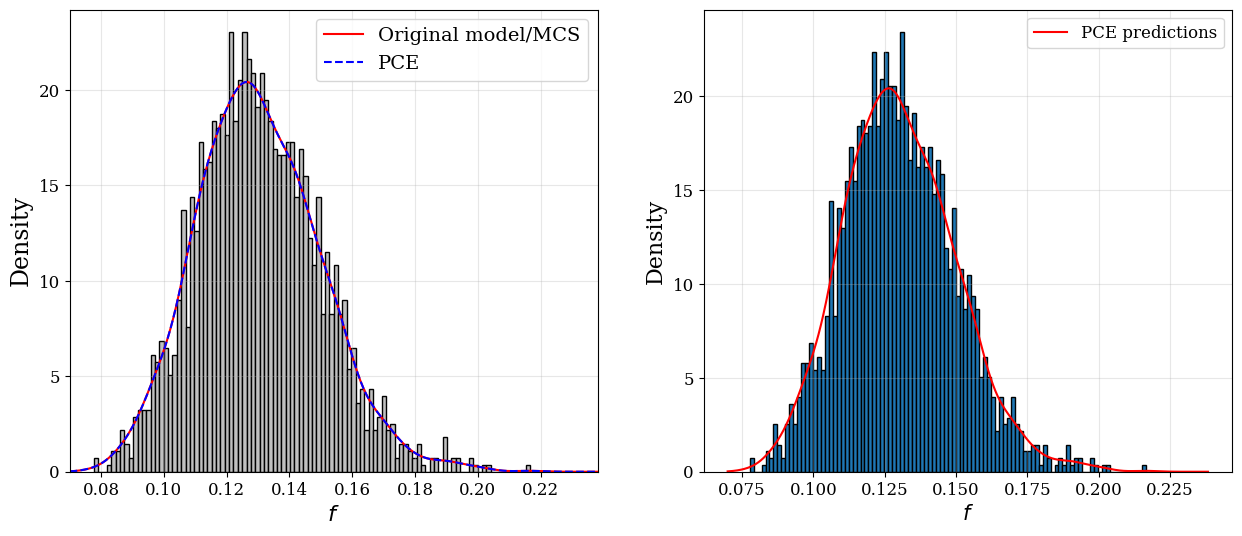

In [13]:
deformation = 1.1

plot_dict = test_dict[deformation]
true_output = plot_dict['real_output']
pce_output = plot_dict['predictions']
# Create subplots

fig, axs = plt.subplots(1, 2, figsize=(15, 6))
x_min = 0.9*np.min(true_output)
x_max = 1.1*np.max(true_output)
x = np.linspace(x_min, x_max, 1000)
n_bins = 100

# Histogram of the original model/MCS output
axs[0].grid(True,alpha=0.3)
axs[0].hist(true_output, bins=n_bins, density=True, edgecolor='black', alpha=1, color="silver")
axs[0].set_xlim(x_min, x_max)
kde_real = gaussian_kde(true_output)
axs[0].plot(x, kde_real(x), label="Original model/MCS", color="red", alpha=1.)
kde1 = gaussian_kde(pce_output)
axs[0].plot(x, kde1(x), label=f"PCE", color="blue", linestyle="--")
axs[0].set_xlabel(f"$f$", fontsize=16)
axs[0].set_ylabel("Density", fontsize=17)
axs[0].legend(fontsize=14)

# Histogram of the PCE predictions
axs[1].grid(True,alpha=0.3)
axs[1].hist(pce_output, bins=n_bins, density=True, edgecolor='black')
kde = gaussian_kde(pce_output)
axs[1].plot(x, kde(x), label="PCE predictions", color="red")
axs[1].set_xlabel("$f$", fontsize=15)
axs[1].set_ylabel("Density", fontsize=16)
axs[1].legend()

# plt.savefig('figures/AN_1_1.pdf', bbox_inches='tight')
# plt.tight_layout()
# plt.show()

In [2]:
'''LOAD RESULTS'''
# os.chdir('..')
# os.chdir('models')
os.getcwd()

'/mnt/c/Users/luisr/OneDrive/Ambiente de Trabalho/PhD/stochastic-biopolymers/notebooks'

In [42]:
file_list = os.listdir()[:18]
print(file_list)

file_id = file_list[0]
# file_id = '20250621_235950_038178'

# # Load test results from pickle file
# with open(f'{file_id}/test_results.pkl', 'rb') as file:
#     test_results = pickle.load(file)

# # Load the pce model from pickle file
# with open(f'{file_id}/pce_model.pkl', 'rb') as file:
#     pce_model = pickle.load(file)

# results = test_results[1.0]
# results # [1.05]
    
r2score_list = []
for file_id in file_list:

    # Load test results from pickle file
    with open(f'{file_id}/test_results.pkl', 'rb') as file:
        test_results = pickle.load(file)

    # Load the pce model from pickle file
    with open(f'{file_id}/pce_model.pkl', 'rb') as file:
        pce_model = pickle.load(file)

    results = test_results[1.0] # [1.05]

    r2score_list.append(results["R2"])

print("R2 scores:")
print(r2score_list, len(r2score_list))

['20250627_143657_669794', '20250627_143657_986602', '20250627_143658_302653', '20250627_143658_578448', '20250627_143658_597551', '20250627_143659_434056', '20250627_143659_680965', '20250627_143659_960467', '20250627_143700_592703', '20250627_143700_813057', '20250627_143701_133866', '20250627_143701_849383', '20250627_143702_150416', '20250627_143702_858191', '20250627_143704_091550', '20250627_143704_429051', '20250627_143704_847570', '20250627_143707_123150']
R2 scores:
[array([ 0.18818807,  0.19397903, -2.17607516]), array([-0.83452545, -0.85838825, -7.26640995]), array([ 0.32671336,  0.29475974, -3.4058187 ]), array([-0.64442031, -0.7130214 , -6.39281712]), array([-13.51490202, -12.82514223, -13.00413938]), array([ -8.81286888,  -8.74284633, -16.21831835]), array([0.7746778 , 0.77321318, 0.62543777]), array([0.38360686, 0.3788813 , 0.18485327]), array([-1.09013546, -1.04706439, -0.38350246]), array([ 0.60247126,  0.600149  , -0.52304906]), array([ 0.26171346,  0.2580975 , -0.815

In [43]:
# Get the indices of the top 10 R2 scores
r2_score_list_mean = [np.mean(r2_array) for r2_array in r2score_list]
print("Mean R2 scores:")
print(r2_score_list_mean, len(r2_score_list_mean))
top_10_indices = np.argsort(r2_score_list_mean)[-10:]
print("Top 10 indices:", top_10_indices)

# Get the top 10 R2 scores
for i in top_10_indices:
    print(f"Idx: {i}, File ID: {file_list[i]}, R2 score: {r2score_list[i]}")

Mean R2 scores:
[np.float64(-0.5979693520641137), np.float64(-2.986441218086991), np.float64(-0.9281152003427394), np.float64(-2.583419610157057), np.float64(-13.114727875434342), np.float64(-11.258011185870274), np.float64(0.7244429190123878), np.float64(0.3157804773616362), np.float64(-0.8402341067323809), np.float64(0.22652373243662915), np.float64(-0.0984730069897501), np.float64(-2.0615624984498555), np.float64(0.6236158211731286), np.float64(-0.013851882698621662), np.float64(-0.5676786478362658), np.float64(0.05369587481684205), np.float64(-0.00044358111526898725), np.float64(-0.013441132949545706)] 18
Top 10 indices: [14 10 13 17 16 15  9  7 12  6]
Idx: 14, File ID: 20250627_143704_091550, R2 score: [-0.7695913  -0.72557724 -0.2078674 ]
Idx: 10, File ID: 20250627_143701_133866, R2 score: [ 0.26171346  0.2580975  -0.81522997]
Idx: 13, File ID: 20250627_143702_858191, R2 score: [ 0.00186381  0.00055555 -0.04397501]
Idx: 17, File ID: 20250627_143707_123150, R2 score: [-0.01987066 

In [176]:
pce_model[1.0], pce_model[1.0].shape

(polynomial([1.4128109222365541*q6**2+7.837620328732616e-07*q5*q6+10.610883286526924*q4*q6-5.6512458509531225*q3*q6+0.029981412948130507*q2*q6+5.44468376922205*q1*q6+3.3808700478906397*q0*q6+8.388174544275366e-09*q5**2+4.9710273460741786e-05*q3*q5+3.9684905650968155e-05*q4*q5-5.264906538322908e-05*q2*q5+0.0002172417516939884*q1*q5-2.5281063483994686*q1*q4+0.006839169901074976*q0*q5+6.358768090760626*q4**2-42.44353284474147*q3*q4+2.053469030503683*q0*q4-0.00012311614065213243*q2*q4+0.007563369833148727*q2*q3+22.60497475583376*q3**2-2.283749769436604*q0*q1+0.052101549834200366*q0**2-21.778733425469017*q1*q3-13.52342819026971*q0*q3-0.00011409306867845204*q1*q2-2.182527108747039e-08*q2**2-4.298722177788761*q1**2+9.677739566500701e-05*q0*q2+2.0313560006542963*q5-1168.5376550667659*q6-298.77660715604816*q3+61.20752992763149*q4-0.047579099209642324*q2+52.1379345248115*q1+18.143777709368116*q0+1824.1055354107025,
             2.309942743714195*q6**2+1.2833684562455601e-06*q5*q6+18.128910685198

In [178]:
test_results
# pce_model

{1.0: {'real_output': array([[1.44618607e-01, 2.45006458e-01, 6.18107667e+00],
         [1.26060135e-01, 2.02023645e-01, 3.94938731e+00],
         [3.57207617e-01, 5.87768896e-01, 1.53860247e+01],
         [2.60698009e-01, 4.35568816e-01, 1.16238307e+01],
         [1.12894239e-01, 1.85322491e-01, 3.95187877e+00],
         [1.61742710e-01, 2.51016284e-01, 4.34936022e+00],
         [7.88465482e-01, 1.26820065e+00, 3.80181224e+01],
         [1.56019235e-01, 2.46084884e-01, 4.57431167e+00],
         [2.44619790e-01, 4.14900579e-01, 1.14977500e+01],
         [2.60973567e-01, 4.36029214e-01, 1.16359816e+01],
         [1.25696724e-01, 2.01441243e-01, 3.94151788e+00],
         [4.14130953e-03, 6.41902978e-03, 5.21896848e-01],
         [6.15434388e-01, 9.81497958e-01, 2.51046783e+01],
         [1.12966002e-01, 1.85440294e-01, 3.95364479e+00],
         [7.91762209e-01, 1.27350324e+00, 3.82086547e+01],
         [2.12589206e-01, 3.53533089e-01, 8.42131458e+00],
         [5.99505536e-01, 9.79451901

In [179]:
keys_list = list(pce_model.keys())
key_id = 0
print(f"Stretch: {keys_list[key_id]}")
pce = pce_model[keys_list[key_id]]
results = test_results[keys_list[key_id]]
pce, results

Stretch: 1.0


(polynomial([1.4128109222365541*q6**2+7.837620328732616e-07*q5*q6+10.610883286526924*q4*q6-5.6512458509531225*q3*q6+0.029981412948130507*q2*q6+5.44468376922205*q1*q6+3.3808700478906397*q0*q6+8.388174544275366e-09*q5**2+4.9710273460741786e-05*q3*q5+3.9684905650968155e-05*q4*q5-5.264906538322908e-05*q2*q5+0.0002172417516939884*q1*q5-2.5281063483994686*q1*q4+0.006839169901074976*q0*q5+6.358768090760626*q4**2-42.44353284474147*q3*q4+2.053469030503683*q0*q4-0.00012311614065213243*q2*q4+0.007563369833148727*q2*q3+22.60497475583376*q3**2-2.283749769436604*q0*q1+0.052101549834200366*q0**2-21.778733425469017*q1*q3-13.52342819026971*q0*q3-0.00011409306867845204*q1*q2-2.182527108747039e-08*q2**2-4.298722177788761*q1**2+9.677739566500701e-05*q0*q2+2.0313560006542963*q5-1168.5376550667659*q6-298.77660715604816*q3+61.20752992763149*q4-0.047579099209642324*q2+52.1379345248115*q1+18.143777709368116*q0+1824.1055354107025,
             2.309942743714195*q6**2+1.2833684562455601e-06*q5*q6+18.128910685198

In [16]:
os.chdir('..')
os.chdir('models')
os.getcwd()
# Read training data dict from csv file in model directory
with open(f'{file_id}/training_data.csv', 'r') as file:
    training_data_dict = json.load(file)

# Get data timestamp from dict
data_timestamp = training_data_dict['data_timestamp']
print(f"Data timestamp: {data_timestamp}")

# Get random inputs and results dataframe from data_timestamp directory
os.chdir('..')
os.chdir('data')
os.getcwd()

with open(f'filament/{data_timestamp}/study_props_info.csv', 'r') as file:
    rnd_inputs = json.load(file)

with open(f'filament/{data_timestamp}/results.pkl', 'rb') as file:
    df_results = pickle.load(file)

# Print random inputs
print(f"Random inputs: {rnd_inputs}")

# Define "distributions" dict
distributions = {
    'normal': cp.Normal,
    'uniform': cp.Uniform,
    'lognormal': cp.LogNormal,
}

# Get joint distribution from random inputs
joint_dist = cp.J(
            *[distributions[value['distribution']](*list(value.values())[1:]) 
            for value in rnd_inputs.values()]
                    )

print(f"Joint distribution: {joint_dist}")

Data timestamp: 20250626_110559_345195
Random inputs: {'R0C': {'distribution': 'uniform', 'low': 0.012, 'high': 0.016}, 'ETA': {'distribution': 'uniform', 'low': 0.4, 'high': 0.6}, 'MU0': {'distribution': 'uniform', 'low': 35000.0, 'high': 42000.0}, 'L': {'distribution': 'uniform', 'low': 1.95, 'high': 2.1}, 'R0F': {'distribution': 'uniform', 'low': 1.6, 'high': 1.7}, 'Lp': {'distribution': 'uniform', 'low': 12.0, 'high': 20.0}, 'STRETCH': {'distribution': 'uniform', 'low': 1.0, 'high': 1.05}}
Joint distribution: J(Uniform(lower=0.012, upper=0.016), Uniform(lower=0.4, upper=0.6), Uniform(lower=35000.0, upper=42000.0), Uniform(lower=1.95, upper=2.1), Uniform(lower=1.6, upper=1.7), Uniform(lower=12.0, upper=20.0), Uniform(lower=1.0, upper=1.05))


In [17]:
df_results.head(10)

,force,deformation,lambda_f,dw,ddw,R0C,ETA,MU0,L,R0F,Lp,STRETCH,split
0,0.045222,1.037272,1.018728,0.076454,4.866249,0.015579,0.497891,37218.454036,1.974440,1.690635,16.487504,1.037272,train
1,0.016358,1.030531,1.014467,0.02675,2.002735,0.013975,0.469842,38655.702820,2.089614,1.635335,15.791693,1.030531,train
2,0.021035,1.026606,1.012561,0.033868,2.941329,0.015796,0.467523,38447.623857,1.967411,1.610112,16.443454,1.026606,train
3,0.020273,1.024226,1.010307,0.03344,3.500581,0.013465,0.422010,37574.010621,1.991990,1.649442,18.736951,1.024226,train
4,0.007593,1.010572,1.00532,0.012433,2.430161,0.012138,0.499450,41404.050732,1.975980,1.637427,13.829142,1.010572,train
5,0.008382,1.009226,1.005225,0.014075,2.797234,0.014447,0.561488,39603.290246,2.032384,1.679158,16.753046,1.009226,train
6,0.003074,1.004088,1.002314,0.005094,2.23111,0.012849,0.561624,36569.885166,2.094397,1.657344,18.928511,1.004088,train
7,0.019136,1.027838,1.014926,0.032341,2.400198,0.013301,0.531997,35251.595917,2.070522,1.690116,13.921165,1.027838,train
8,0.002213,1.003054,1.001726,0.003606,2.11233,0.013217,0.560734,37277.797887,2.011343,1.629321,15.011707,1.003054,train
9,0.012766,1.017805,1.008503,0.020576,2.550665,0.013555,0.473557,39305.050587,2.008225,1.611753,17.632638,1.017805,train


In [18]:
pce_constructor = PCEConstructor(df_results, rnd_inputs, joint_dist)
poly_basis, _ = pce_constructor.poly_basis(degree=2, normed=True)

In [19]:
q0, q1, q2, q3, q4, q5, q6 = cp.variable(7)
aux_poly = cp.E_cond(pce, q6, dist=joint_dist)
cp.E(pce, joint_dist), pce(0.014, 0.5, 38600, 2.0, 1.65, 16.0, 1.025), aux_poly, aux_poly(q6=1.0259)

(array([0.02057588, 0.0340878 , 2.84983586]),
 array([ -3.64547682,  -6.50954128, -79.52518126]),
 polynomial([0.0015092270197534462*q6**3+0.048108954873203*q6**2+0.7210627147730094*q6-0.7706941368730025,
             0.002870978965035397*q6**3+0.08784199260934236*q6**2+1.1659532418149525*q6-1.2564151394136103,
             0.130656452272922*q6**3+2.9412817747855695*q6**2+12.439821399153328*q6-13.132564414929293]),
 array([0.02130693, 0.03528731, 2.86613524]))

In [29]:
# Get the type of auxpoly
aux_poly(q6=1.025)

array([0.02134131, 0.03528165, 3.08007507])

In [ ]:
################ HERE #################

# Obtain the polynomial with the last random fixed at 1.1 !!!!!!!
pce_fix_stretch = pce(*[None, None, None, None, None, None, 1.01])

# Remove stretch from the joint distribution
joint_dist_fix_stretch = joint_dist[:6]
print(f"Joint distribution with fixed stretch: {joint_dist_fix_stretch}")

Joint distribution with fixed stretch: J(Normal(mu=0.014, sigma=0.002), Normal(mu=0.5, sigma=0.05), Normal(mu=38600.0, sigma=2000.0), Uniform(lower=1.95, upper=2.05), Uniform(lower=1.6, upper=1.7), Normal(mu=16.0, sigma=1.6))


In [192]:
# SOBOL indices

# Full polynomials
sobol_indices = cp.Sens_m(pce, joint_dist)
sobol_indices_m2 = cp.Sens_m2(pce, joint_dist)
sobol_indices_t = cp.Sens_t(pce, joint_dist)

# Fixed stretch
# sobol_indices = cp.Sens_m(pce_fix_stretch, joint_dist_fix_stretch)
# sobol_indices_m2 = cp.Sens_m2(pce_fix_stretch, joint_dist_fix_stretch)
# sobol_indices_t = cp.Sens_t(pce_fix_stretch, joint_dist_fix_stretch)
print(f"Sobol indices m: {sobol_indices}")
print(f"Sobol indices m2: {sobol_indices_m2}")
print(f"Sobol indices t: {sobol_indices_t}")

Sobol indices m: [[0.8151489  0.81500349 0.80921537]
 [0.18434406 0.18433725 0.18747077]]
Sobol indices m2: [[[0.         0.         0.        ]
  [0.00050704 0.00065926 0.00331386]]

 [[0.00050704 0.00065926 0.00331386]
  [0.         0.         0.        ]]]
Sobol indices t: [[0.81565594 0.81566275 0.81252923]
 [0.1848511  0.18499651 0.19078463]]


In [180]:
predictions = results['predictions']
true_output = results['real_output']

print(f'r2 score: {results["R2"]}')
print(len(predictions), len(predictions[predictions < 0]))
print(predictions[predictions < 0])
print(true_output[predictions < 0])

r2 score: [0.97355885 0.97207202 0.92713803]
200 0
[]
[]


In [181]:
true_output.shape, predictions.shape

((200, 3), (200, 3))

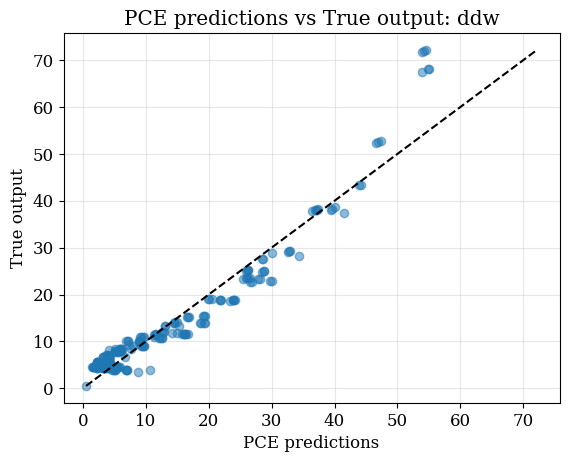

In [184]:
QOI_list = ['force', 'dw', 'ddw']
iQOI = 2
predictions_plot = predictions[:, iQOI]
true_output_plot = true_output[:, iQOI]

plt.plot(predictions_plot, true_output_plot, 'o', alpha=0.5)
# plot line with slope 1
plt.plot([np.min(true_output_plot), np.max(true_output_plot)], [np.min(true_output_plot), np.max(true_output_plot)], 'k--', alpha=1)
plt.xlabel("PCE predictions")
plt.ylabel("True output")
plt.title(f"PCE predictions vs True output: {QOI_list[iQOI]}")
plt.grid(True, alpha=0.3)
# plt.xlim(-0.1,1.5)
# plt.ylim(-0.1,1.5)

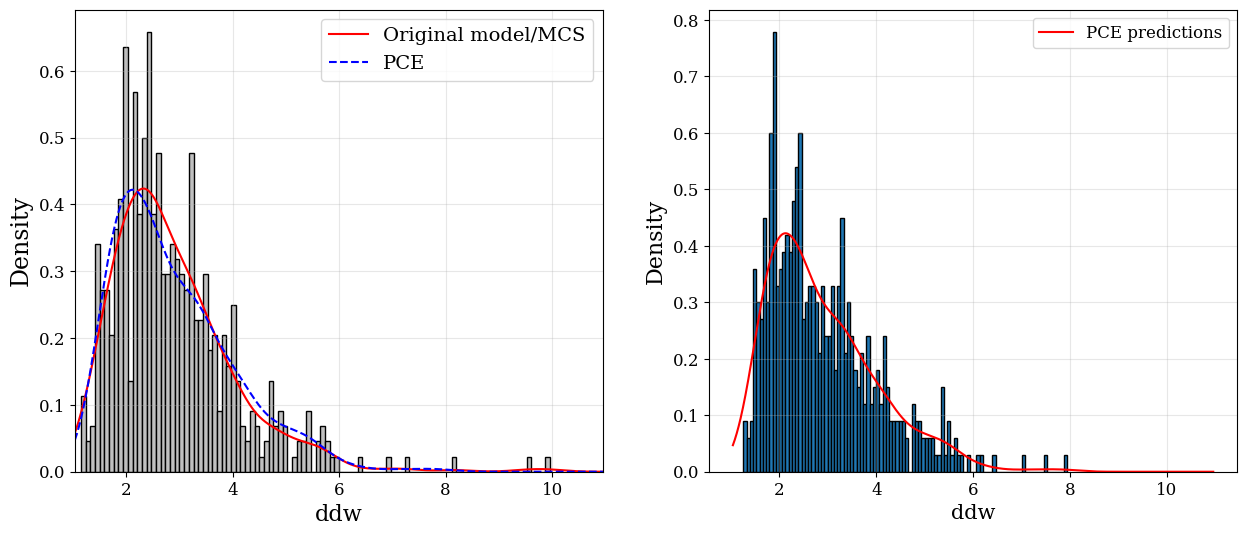

In [84]:
# deformation = 1.0

# plot_dict = test_results[deformation]
# true_output = plot_dict['real_output']
pce_output = predictions# plot_dict['predictions']

QOI_list = ['force', 'dw', 'ddw']
iQOI = 2
pce_output_plot = predictions[:, iQOI]
true_output_plot = true_output[:, iQOI]

# Create subplots
fig, axs = plt.subplots(1, 2, figsize=(15, 6))
x_min = 0.9*np.min(true_output_plot)
x_max = 1.1*np.max(true_output_plot)
x = np.linspace(x_min, x_max, 1000)
n_bins = 100

# Histogram of the original model/MCS output
axs[0].grid(True,alpha=0.3)
axs[0].hist(true_output_plot, bins=n_bins, density=True, edgecolor='black', alpha=1, color="silver")
axs[0].set_xlim(x_min, x_max)
kde_real = gaussian_kde(true_output_plot)
axs[0].plot(x, kde_real(x), label="Original model/MCS", color="red", alpha=1.)
kde1 = gaussian_kde(pce_output_plot)
axs[0].plot(x, kde1(x), label=f"PCE", color="blue", linestyle="--")
axs[0].set_xlabel(f"{QOI_list[iQOI]}", fontsize=16)
axs[0].set_ylabel("Density", fontsize=17)
axs[0].legend(fontsize=14)

# Histogram of the PCE predictions
axs[1].grid(True,alpha=0.3)
axs[1].hist(pce_output_plot, bins=n_bins, density=True, edgecolor='black')
kde = gaussian_kde(pce_output_plot)
axs[1].plot(x, kde(x), label="PCE predictions", color="red")
axs[1].set_xlabel(f"{QOI_list[iQOI]}", fontsize=15)
axs[1].set_ylabel("Density", fontsize=16)
axs[1].legend()

# plt.savefig('figures/AN_1_1.pdf', bbox_inches='tight')
# plt.tight_layout()
# plt.show()

# 2. Results

## 2.0 Training data

In [135]:
'''LOAD RESULTS'''
# os.chdir('..')
os.chdir('models')
os.getcwd()

'/mnt/c/Users/luisr/OneDrive/Ambiente de Trabalho/PhD/stochastic-biopolymers/models'

In [ ]:
# file_list = os.listdir()[:28]
# print(file_list)

# file_id = file_list[12]
# file_list = ['best/1_1/sobol_5000_LS_d2', 'best/1_2/korobov_1000_LS_d2', 'best/1_3/korobov_1000_LS_d2', 'best/1_4/korobov_1000_LS_d2']

os.chdir('..')
os.chdir('models')
os.getcwd()
# file_list = os.listdir()[:25]
# file_id = 'best/1_/korobov_1000_LS_d2'

distributions = {
    'normal': cp.Normal,
    'uniform': cp.Uniform,
    'lognormal': cp.LogNormal,
}

'''LOAD TEST RESULTS AND PCE MODEL FROM A SINGLE MODEL'''
# # Load test results from pickle file
# with open(f'{file_id}/test_results.pkl', 'rb') as file:
#     test_results = pickle.load(file)

# # Load the pce model from pickle file
# with open(f'{file_id}/pce_model.pkl', 'rb') as file:
#     pce_model = pickle.load(file)

# results = test_results[1.0]
# results # [1.05]

'''LOAD TEST RESULTS AND PCE MODEL FROM A LIST OF MODELS'''
r2score_list = []
test_results_list = []
pce_model_list = []
for file_id in file_list:

    # Load test results from pickle file
    with open(f'{file_id}/test_results.pkl', 'rb') as file:
        test_results = pickle.load(file)

    # Load the pce model from pickle file
    with open(f'{file_id}/pce_model.pkl', 'rb') as file:
        pce_model = pickle.load(file)
    
    # test_results_list.append(test_results)
    pce_model_list.append(pce_model)

    # results = test_results[1.0] # [1.05]

    # r2score_list.append(results["R2"])

'''GET TEST RESULTS FROM INCREASED TEST SETS'''
os.chdir('..')
os.chdir('data')
os.getcwd()

data_file_id = 'test_set_random'
## Load test results
with open(f'filament/{data_file_id}/results.pkl', 'rb') as file:
    df_results = pickle.load(file)

with open(f'filament/{data_file_id}/study_props_info.csv', 'r') as file:
    rnd_inputs = json.load(file)

test_results_list = []
# Build a pce constructor for each evaluation, constrained by stretch values
for i, pce_model in enumerate(pce_model_list):
    deformation_min = 1.00 # 1.0 + 0.05*i
    deformation_max = 1.05 # deformation_min + 0.05
    # print(f"i: {i}")
    # print(f"deformation_min: {deformation_min}")
    # print(f"deformation_max: {deformation_max}")
    # print(pce_model)
    filtered_df = df_results[(df_results['STRETCH']>deformation_min) & (df_results['STRETCH']<deformation_max)]
    pce_constructor = PCEConstructor(df=filtered_df, rnd_inputs=rnd_inputs, y_columns=['force', 'dw', 'ddw'])
    # Test each pce, creating a dictionary of test results
    test_results = pce_constructor.test_pce(pce_model)
    # Create a test_result list. From here on, the pipeline is implemented
    test_results_list.append(test_results)

joint_dist = cp.J(
            *[distributions[value['distribution']](*list(value.values())[1:]) 
            for value in rnd_inputs.values()]
                    )


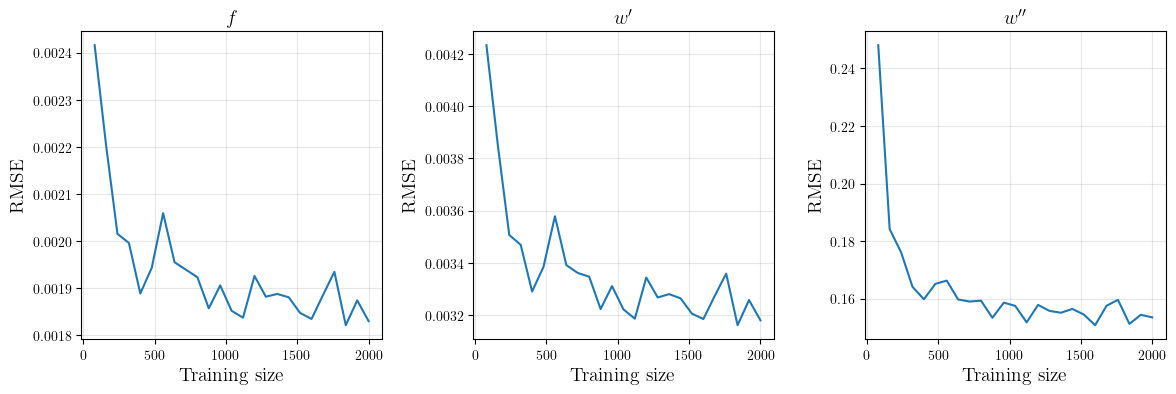

In [18]:
eval_metrics_list = [{key: results[1.0][key]} for results in test_results_list for key in ['RMSE']]
f_error = np.array([list(metrics.values())[0][0] for metrics in eval_metrics_list])
dw_error = np.array([list(metrics.values())[0][1] for metrics in eval_metrics_list])
ddw_error = np.array([list(metrics.values())[0][2] for metrics in eval_metrics_list])
x = 0.8*np.array(range(100, 2501, 100))
x

fig, ax = plt.subplots(1, 3, figsize=(14, 4))
ax[0].plot(x, f_error)
ax[0].set_title('$f$')
ax[1].plot(x, dw_error)
ax[1].set_title('$w^{\\prime}$')
ax[2].plot(x, ddw_error)
ax[2].set_title('$w^{\\prime\\prime}$')

for a in ax:
    a.set_xlabel('Training size', fontsize=14)
    a.set_ylabel('RMSE', fontsize=14)
    a.grid(True, alpha=0.3)

plt.subplots_adjust(wspace=0.3)

# os.chdir('..')
plt.savefig('figures/PCE_train.svg', bbox_inches='tight')


## 2.1 PCE Evaluation

In [3]:
'''LOAD RESULTS'''
# os.chdir('..')
# os.chdir('models')
os.getcwd()

'/mnt/c/Users/luisr/OneDrive/Ambiente de Trabalho/PhD/stochastic-biopolymers/notebooks'

In [21]:
# file_list = os.listdir()[:28]
# print(file_list)

# file_id = file_list[12]
# file_list = ['best/1_1/sobol_5000_LS_d2', 'best/1_2/korobov_1000_LS_d2', 'best/1_3/korobov_1000_LS_d2', 'best/1_4/korobov_1000_LS_d2']

os.chdir('..')
os.chdir('models')
os.getcwd()
# file_list = os.listdir('best/1_4_1')
file_list = ['best/1_1/rnd_500_LS_d2', 'best/1_2/LHS_500_LS_d2', 'best/1_3_1/rnd_500_LS_d2', 'best/1_3_2/rnd_2500_LS_d2']
file_id = 'best/1_2/LHS_500_LS_d2'

distributions = {
    'normal': cp.Normal,
    'uniform': cp.Uniform,
    'lognormal': cp.LogNormal,
}

'''LOAD TEST RESULTS AND PCE MODEL FROM A SINGLE MODEL'''
# Load test results from pickle file
with open(f'{file_id}/test_results.pkl', 'rb') as file:
    test_results = pickle.load(file)

# Load the pce model from pickle file
with open(f'{file_id}/pce_model.pkl', 'rb') as file:
    pce_model = pickle.load(file)

pce_model_list = [pce_model]

results = test_results[1.0]
results # [1.05]

'''LOAD TEST RESULTS AND PCE MODEL FROM A LIST OF MODELS'''
# r2score_list = []
# test_results_list = []
# pce_model_list = []
# for file_id in file_list:

#     # Load test results from pickle file
#     with open(f'{file_id}/test_results.pkl', 'rb') as file:
#         test_results = pickle.load(file)

#     # Load the pce model from pickle file
#     with open(f'{file_id}/pce_model.pkl', 'rb') as file:
#         pce_model = pickle.load(file)
    
#     # test_results_list.append(test_results)
#     pce_model_list.append(pce_model)

#     # results = test_results[1.0] # [1.05]

#     # r2score_list.append(results["R2"])

'''GET TEST RESULTS FROM INCREASED TEST SETS'''
os.chdir('..')
os.chdir('data')
os.getcwd()

data_file_id = 'test_set_random'
## Load test results
with open(f'filament/{data_file_id}/results.pkl', 'rb') as file:
    df_results = pickle.load(file)

with open(f'filament/{data_file_id}/study_props_info.csv', 'r') as file:
    rnd_inputs = json.load(file)

test_results_list = []
# Build a pce constructor for each evaluation, constrained by stretch values
# def_min_list = [1.00, 1.05, 1.10, 1.125]
# def_max_list = [1.05, 1.10, 1.125, 1.15]
for i, pce_model in enumerate(pce_model_list):
    deformation_min = 1.05 # 1.1 + 0.025*i
    deformation_max = 1.1 # deformation_min + 0.025
    print(f"i: {i}")
    print(f"deformation_min: {deformation_min}")
    print(f"deformation_max: {deformation_max}")
    print(pce_model)
    filtered_df = df_results[(df_results['STRETCH']>deformation_min) & (df_results['STRETCH']<deformation_max)]
    pce_constructor = PCEConstructor(df=filtered_df, rnd_inputs=rnd_inputs, y_columns=['force', 'dw', 'ddw'])
    # Test each pce, creating a dictionary of test results
    test_results = pce_constructor.test_pce(pce_model)
    # Create a test_result list. From here on, the pipeline is implemented
    test_results_list.append(test_results)

joint_dist = cp.J(
            *[distributions[value['distribution']](*list(value.values())[1:]) 
            for value in rnd_inputs.values()]
                    )


i: 0
deformation_min: 1.05
deformation_max: 1.1
{1.0: polynomial([8.394621433922326*q6**2+0.11949324852708688*q5*q6+9.22978198838971*q4*q6-8.99250033787642*q3*q6-1.0381239054536138e-05*q2*q6+5.5939781675954245*q1*q6-45.818876326069294*q0*q6-3.387291907302227e-05*q5**2-0.02787930551403024*q3*q5+0.03349342894072869*q4*q5+7.531654000758551e-08*q2*q5+0.02062331510830509*q1*q5+1.5146652915929342*q1*q4+0.07231134159402952*q0*q5+1.5769846616690113*q4**2-3.2168889088145463*q3*q4-8.992142799066126*q0*q4-7.610508769778005e-08*q2*q4-7.121446816340802e-07*q2*q3+1.6109469379074555*q3**2-8.5408888775812*q0*q1-79.60258670284661*q0**2-1.5715280174627773*q1*q3+3.5367084754140454*q0*q3-2.255040020331467e-06*q1*q2-1.9141351347419236e-11*q2**2+0.2947947587574968*q1**2-1.1924527771087368e-05*q0*q2-0.13543377170451093*q5-17.31832688728393*q6+9.279193264400849*q3-9.376585222755516*q4+1.4300197626020919e-05*q2-5.525561514181602*q1+62.42688100691741*q0+8.670518873056746,
            13.68585976460517*q6**2+0.1

In [22]:
eval_metrics_list = [{key: results[1.0][key]} for results in test_results_list for key in ['R2', 'RMSE', 'MSE', 'MAE']]
eval_metrics_list

[{'R2': array([0.97275449, 0.97155942, 0.94687198])},
 {'RMSE': array([0.00742452, 0.01277795, 0.65909562])},
 {'MSE': array([5.51235335e-05, 1.63276000e-04, 4.34407032e-01])},
 {'MAE': array([0.00502245, 0.00866923, 0.43309976])}]

In [25]:
pce_id = 0
pce = pce_model_list[pce_id][1.0]
pce

polynomial([8.394621433922326*q6**2+0.11949324852708688*q5*q6+9.22978198838971*q4*q6-8.99250033787642*q3*q6-1.0381239054536138e-05*q2*q6+5.5939781675954245*q1*q6-45.818876326069294*q0*q6-3.387291907302227e-05*q5**2-0.02787930551403024*q3*q5+0.03349342894072869*q4*q5+7.531654000758551e-08*q2*q5+0.02062331510830509*q1*q5+1.5146652915929342*q1*q4+0.07231134159402952*q0*q5+1.5769846616690113*q4**2-3.2168889088145463*q3*q4-8.992142799066126*q0*q4-7.610508769778005e-08*q2*q4-7.121446816340802e-07*q2*q3+1.6109469379074555*q3**2-8.5408888775812*q0*q1-79.60258670284661*q0**2-1.5715280174627773*q1*q3+3.5367084754140454*q0*q3-2.255040020331467e-06*q1*q2-1.9141351347419236e-11*q2**2+0.2947947587574968*q1**2-1.1924527771087368e-05*q0*q2-0.13543377170451093*q5-17.31832688728393*q6+9.279193264400849*q3-9.376585222755516*q4+1.4300197626020919e-05*q2-5.525561514181602*q1+62.42688100691741*q0+8.670518873056746,
            13.68585976460517*q6**2+0.19714540408520434*q5*q6+16.542095226266174*q4*q6-14.826

In [27]:
keys_list = list(pce_model.keys())
key_id = 0
print(f"Stretch: {keys_list[key_id]}")
pce = pce_model[keys_list[key_id]]
results = test_results[keys_list[key_id]]
pce, results

Stretch: 1.0


(polynomial([8.394621433922326*q6**2+0.11949324852708688*q5*q6+9.22978198838971*q4*q6-8.99250033787642*q3*q6-1.0381239054536138e-05*q2*q6+5.5939781675954245*q1*q6-45.818876326069294*q0*q6-3.387291907302227e-05*q5**2-0.02787930551403024*q3*q5+0.03349342894072869*q4*q5+7.531654000758551e-08*q2*q5+0.02062331510830509*q1*q5+1.5146652915929342*q1*q4+0.07231134159402952*q0*q5+1.5769846616690113*q4**2-3.2168889088145463*q3*q4-8.992142799066126*q0*q4-7.610508769778005e-08*q2*q4-7.121446816340802e-07*q2*q3+1.6109469379074555*q3**2-8.5408888775812*q0*q1-79.60258670284661*q0**2-1.5715280174627773*q1*q3+3.5367084754140454*q0*q3-2.255040020331467e-06*q1*q2-1.9141351347419236e-11*q2**2+0.2947947587574968*q1**2-1.1924527771087368e-05*q0*q2-0.13543377170451093*q5-17.31832688728393*q6+9.279193264400849*q3-9.376585222755516*q4+1.4300197626020919e-05*q2-5.525561514181602*q1+62.42688100691741*q0+8.670518873056746,
             13.68585976460517*q6**2+0.19714540408520434*q5*q6+16.542095226266174*q4*q6-14.8

In [28]:
pce_id = 0
results = test_results_list[pce_id][1.0]

predictions = results['predictions']
true_output = results['real_output']

print(f'r2 score: {results["R2"]}')
print(f'mse: {results["MSE"]}')
print(f'mae: {results["MAE"]}')
print(f'rmse: {results["RMSE"]}')
print(len(predictions), len(predictions[predictions < 0]))
# print(predictions[predictions < 0])
# print(true_output[predictions < 0])

r2 score: [0.97275449 0.97155942 0.94687198]
mse: [5.51235335e-05 1.63276000e-04 4.34407032e-01]
mae: [0.00502245 0.00866923 0.43309976]
rmse: [0.00742452 0.01277795 0.65909562]
508 0


In [29]:
real_output_list = [results[1.0]['real_output'] for results in test_results_list]
predictions_list = [results[1.0]['predictions'] for results in test_results_list]

# Vstack the arrays in real_output_list
true_output_all = np.vstack(real_output_list)
predictions_all = np.vstack(predictions_list)

In [30]:
true_output_all.shape, predictions_all.shape

((508, 3), (508, 3))

In [31]:
# Get R2 score for true_output_all and predictions_all
R2 = 1 - (np.sum((predictions_all - true_output_all) ** 2, axis=0) / np.sum((true_output_all - np.mean(true_output_all, axis=0)) ** 2, axis=0))
MAE = np.mean(abs(predictions_all - true_output_all), axis=0)
MSE = np.mean(((predictions_all - true_output_all)) ** 2, axis=0)
RMSE = np.sqrt(MSE)
print(f'R2: {R2}')
print(f'MAE: {MAE}')
print(f'MSE: {MSE}')
print(f'RMSE: {RMSE}')


R2: [0.97275449 0.97155942 0.94687198]
MAE: [0.00502245 0.00866923 0.43309976]
MSE: [5.51235335e-05 1.63276000e-04 4.34407032e-01]
RMSE: [0.00742452 0.01277795 0.65909562]


<>:2: SyntaxWarning: invalid escape sequence '\p'
<>:2: SyntaxWarning: invalid escape sequence '\p'
<>:5: SyntaxWarning: invalid escape sequence '\m'
<>:23: SyntaxWarning: invalid escape sequence '\m'
<>:2: SyntaxWarning: invalid escape sequence '\p'
<>:2: SyntaxWarning: invalid escape sequence '\p'
<>:5: SyntaxWarning: invalid escape sequence '\m'
<>:23: SyntaxWarning: invalid escape sequence '\m'
/tmp/ipykernel_22096/3019437770.py:2: SyntaxWarning: invalid escape sequence '\p'
  QOI_symbols = ['$f$', '$w^{\prime}$', '$w^{\prime\prime}$']
/tmp/ipykernel_22096/3019437770.py:2: SyntaxWarning: invalid escape sequence '\p'
  QOI_symbols = ['$f$', '$w^{\prime}$', '$w^{\prime\prime}$']
/tmp/ipykernel_22096/3019437770.py:5: SyntaxWarning: invalid escape sequence '\m'
  fig.suptitle('$\mathbf{\lambda \in [1.05,1.1)}$', fontsize=18)
/tmp/ipykernel_22096/3019437770.py:23: SyntaxWarning: invalid escape sequence '\m'
  axs[iQOI].set_title(f"$\mathrm{{RMSE}} = $ {RMSE[iQOI]:.3f}", fontsize=15)


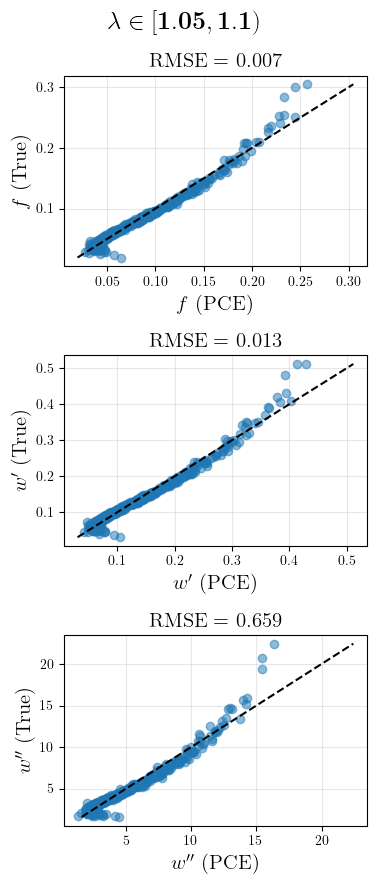

In [33]:
QOI_list = ['force', 'dw', 'ddw']
QOI_symbols = ['$f$', '$w^{\prime}$', '$w^{\prime\prime}$']
fig, axs = plt.subplots(3, 1, figsize=(4, 9))

fig.suptitle('$\mathbf{\lambda \in [1.05,1.1)}$', fontsize=18)

for iQOI in range(3):
    predictions_plot = predictions_all[:, iQOI]
    true_output_plot = true_output_all[:, iQOI]
    # Sort predictions_plot and true_output_plot
    # sort_indices = np.argsort(true_output_plot)
    # predictions_plot = predictions_plot[sort_indices][:-1]
    # true_output_plot = true_output_plot[sort_indices][:-1]
    axs[iQOI].plot(predictions_plot, true_output_plot, 'o', alpha=0.5)
    axs[iQOI].plot(
        [np.min(true_output_plot), np.max(true_output_plot)],
        [np.min(true_output_plot), np.max(true_output_plot)],
        'k--', alpha=1
    )
    axs[iQOI].set_xlabel(f"{QOI_symbols[iQOI]} (PCE)", fontsize=15)
    axs[iQOI].set_ylabel(f"{QOI_symbols[iQOI]} (True)", fontsize=15)
    # axs[iQOI].set_title(f"$\mathrm{{RMSE}} = $ {results['RMSE'][iQOI]:.3f}", fontsize=15)
    axs[iQOI].set_title(f"$\mathrm{{RMSE}} = $ {RMSE[iQOI]:.3f}", fontsize=15)
    axs[iQOI].grid(True, alpha=0.3)
    # axs[iQOI].set_xlim(np.min(true_output_plot), 0.75*np.max(true_output_plot))
    # axs[iQOI].set_ylim(np.min(true_output_plot), 0.75*np.max(true_output_plot))

plt.tight_layout()

os.chdir('..')
os.chdir('figures')
plt.savefig('PCE_eval_2.svg', bbox_inches='tight')

## 2.2 Uncertainty Quantification

In [34]:
'''LOAD RESULTS'''
# os.chdir('..')
# os.chdir('models')
os.getcwd()

'/mnt/c/Users/luisr/OneDrive/Ambiente de Trabalho/PhD/stochastic-biopolymers/figures'

In [62]:
# file_list = os.listdir()[:28]
# print(file_list)

# file_id = file_list[12]
# file_list = ['best/1_1/sobol_5000_LS_d2', 'best/1_2/korobov_1000_LS_d2', 'best/1_3/korobov_1000_LS_d2', 'best/1_4/korobov_1000_LS_d2']

os.chdir('..')
os.chdir('models')
os.getcwd()
# file_list = os.listdir('best/1_4_1')
file_list = ['best/1_1/rnd_500_LS_d2', 'best/1_2/LHS_500_LS_d2', 'best/1_3_1/rnd_500_LS_d2', 'best/1_3_2/rnd_2500_LS_d2']
file_id = 'best/1_2/LHS_500_LS_d2'

distributions = {
    'normal': cp.Normal,
    'uniform': cp.Uniform,
    'lognormal': cp.LogNormal,
}

'''LOAD TEST RESULTS AND PCE MODEL FROM A LIST OF MODELS'''
r2score_list = []
test_results_list = []
pce_model_list = []
for file_id in file_list:

    # Load test results from pickle file
    with open(f'{file_id}/test_results.pkl', 'rb') as file:
        test_results = pickle.load(file)

    # Load the pce model from pickle file
    with open(f'{file_id}/pce_model.pkl', 'rb') as file:
        pce_model = pickle.load(file)
    
    # test_results_list.append(test_results)
    pce_model_list.append(pce_model)

    # results = test_results[1.0] # [1.05]

    # r2score_list.append(results["R2"])

'''GET TEST RESULTS FROM INCREASED TEST SETS'''
os.chdir('..')
os.chdir('data')
os.getcwd()

data_file_id = 'test_set_random'
## Load test results
with open(f'filament/{data_file_id}/results.pkl', 'rb') as file:
    df_results = pickle.load(file)

with open(f'filament/{data_file_id}/study_props_info.csv', 'r') as file:
    rnd_inputs = json.load(file)

# for i, pce_model in enumerate(pce_model_list):
#     deformation_min = 1.05 # 1.1 + 0.025*i
#     deformation_max = 1.1 # deformation_min + 0.025
#     print(f"i: {i}")
#     print(f"deformation_min: {deformation_min}")
#     print(f"deformation_max: {deformation_max}")
#     print(pce_model)
#     filtered_df = df_results[(df_results['STRETCH']>deformation_min) & (df_results['STRETCH']<deformation_max)]
#     pce_constructor = PCEConstructor(df=filtered_df, rnd_inputs=rnd_inputs, y_columns=['force', 'dw', 'ddw'])
#     Test each pce, creating a dictionary of test results
#     test_results = pce_constructor.test_pce(pce_model)
#     Create a test_result list. From here on, the pipeline is implemented
#     test_results_list.append(test_results)

joint_dist = cp.J(
            *[distributions[value['distribution']](*list(value.values())[1:]) 
            for value in rnd_inputs.values()]
                    )

In [63]:
pce_model_list


[{1.0: polynomial([3.7237861627748834*q6**2+0.05892838992428984*q5*q6+3.7120841449606035*q4*q6-3.9457427626091315*q3*q6+2.276022009179977e-06*q2*q6+2.1704582410773536*q1*q6+1.0580015347727674*q0*q6-4.112895757196831e-05*q5**2-0.0058919822983419185*q3*q5+0.005249136430124572*q4*q5+2.6868422822551425e-09*q2*q5+0.0027777859060660165*q1*q5+0.20592158421935247*q1*q4+0.015561242364405908*q0*q5+0.2775274110026534*q4**2-0.5513397035350758*q3*q4-0.8100552891858892*q0*q4+4.1905602128935806e-07*q2*q4+2.3637300493738728e-07*q2*q3+0.28127937627971306*q3**2+0.4075728832459199*q0*q1+8.973238140664037*q0**2-0.2067371398782022*q1*q3-0.8419336003491042*q0*q3-1.007822218403635e-07*q1*q2+8.320652691835177e-12*q2**2+0.02737358109506549*q1**2+9.236523326440259e-06*q0*q2-0.056211435603064984*q5-7.005962318368544*q6+3.9277340495640716*q3-3.7155642644335223*q4-4.2627064172930655e-06*q2-2.170903721450737*q1+0.8288033263178063*q0+3.3086162122415663,
              6.1063897744466855*q6**2+0.09635586105311249*q5*q

In [76]:
# Create stretch array
stretch_array = np.linspace(1.00, 1.15, 10)
# Preallocate arrays for mean and std of each QOI
mean_array = np.zeros((len(stretch_array), 3))
std_array = np.zeros((len(stretch_array), 3))

for i, stretch in enumerate(stretch_array):
    if stretch < 1.05:
        pce_model = pce_model_list[0][1.0]
    elif stretch < 1.10:
        pce_model = pce_model_list[1][1.0]
    elif stretch < 1.125:
        pce_model = pce_model_list[2][1.0]
    else:
        pce_model = pce_model_list[3][1.0]
    q0, q1, q2, q3, q4, q5, q6 = cp.variable(7)
    aux_poly = cp.E_cond(pce_model, q6, dist=joint_dist)
    mean_array[i, :] = aux_poly(q6=stretch)
    std_array[i, :] = cp.Std(pce_model(*[None, None, None, None, None, None, stretch]), joint_dist)

force_array = mean_array[:, 0]
dw_array = mean_array[:, 1]
ddw_array = mean_array[:, 2]
force_std_array = std_array[:, 0]
dw_std_array = std_array[:, 1]
ddw_std_array = std_array[:, 2]


<>:18: SyntaxWarning: invalid escape sequence '\l'
<>:18: SyntaxWarning: invalid escape sequence '\l'
/tmp/ipykernel_22096/978999802.py:18: SyntaxWarning: invalid escape sequence '\l'
  a.set_xlabel('$\lambda$', fontsize=14)


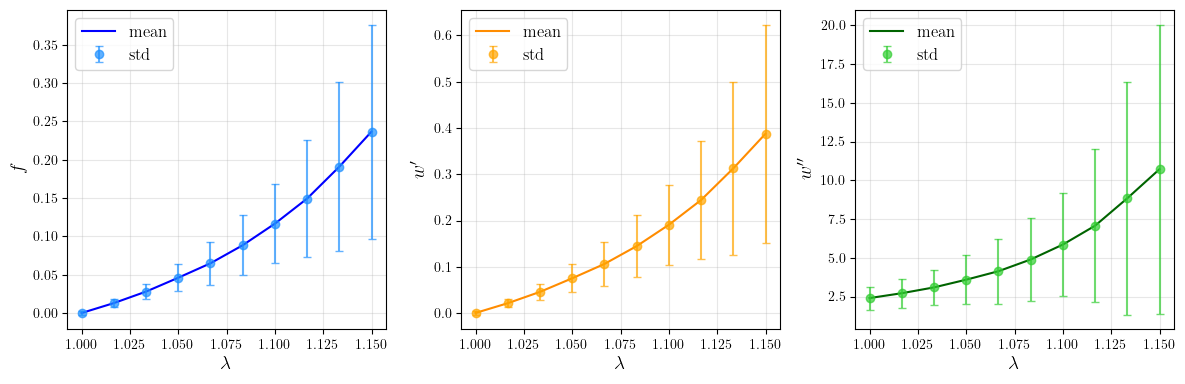

In [93]:
fig, ax = plt.subplots(1, 3, figsize=(12, 4))

ax[0].plot(stretch_array, force_array, label='mean', color='blue')
# ax[0].plot(stretch_array, force_array + force_std_array, color='blue', linestyle='--', alpha=0.7, label='std')
# ax[0].plot(stretch_array, force_array - force_std_array, color='blue', linestyle='--', alpha=0.7)
ax[0].errorbar(stretch_array, force_array, yerr=force_std_array, fmt='o', label='std', color='dodgerblue', capsize=3, alpha=0.7)
ax[0].set_ylabel('$f$', fontsize=14)

ax[1].plot(stretch_array, dw_array, label='mean', color='darkorange')
ax[1].errorbar(stretch_array, dw_array, yerr=dw_std_array, fmt='o', label='std', color='orange', capsize=3, alpha=0.7)
ax[1].set_ylabel('$w^{\\prime}$', fontsize=14)

ax[2].plot(stretch_array, ddw_array, label='mean', color='darkgreen')
ax[2].errorbar(stretch_array, ddw_array, yerr=ddw_std_array, fmt='o', label='std', color='limegreen', capsize=3, alpha=0.7)
ax[2].set_ylabel('$w^{\\prime\\prime}$', fontsize=14)

for a in ax:
    a.set_xlabel('$\lambda$', fontsize=14)
    a.grid(True, alpha=0.3)
    a.legend(fontsize=12)
plt.tight_layout()

os.chdir('..')
os.chdir('figures')
plt.savefig('PCE_un_quant.svg', bbox_inches='tight')


In [99]:
# Get mean and standard deviations for stretch=1.05 and stretch = 1.10
stretch = 1.05
pce_model = pce_model_list[1][1.0]

q0, q1, q2, q3, q4, q5, q6 = cp.variable(7)
aux_poly = cp.E_cond(pce_model, q6, dist=joint_dist)
mean = aux_poly(q6=stretch)
std = cp.Std(pce_model(*[None, None, None, None, None, None, stretch]), joint_dist)
print(f"Mean for stretch={stretch}: {mean}")
print(f"Standard deviation for stretch={stretch}: {std}")
# Print standard deviation in percentage of mean value
print(f"Standard deviation in percentage of mean value for stretch={stretch}: {std/mean*100}%")

stretch = 1.1
pce_model = pce_model_list[2][1.0]

q0, q1, q2, q3, q4, q5, q6 = cp.variable(7)
aux_poly = cp.E_cond(pce_model, q6, dist=joint_dist)
mean = aux_poly(q6=stretch)
std = cp.Std(pce_model(*[None, None, None, None, None, None, stretch]), joint_dist)
print(f"Mean for stretch={stretch}: {mean}")
print(f"Standard deviation for stretch={stretch}: {std}")
# Print standard deviation in percentage of mean value
print(f"Standard deviation in percentage of mean value for stretch={stretch}: {std/mean}")


Mean for stretch=1.05: [0.04617139 0.07528027 3.59259058]
Standard deviation for stretch=1.05: [0.01758039 0.03027523 1.56580457]
Standard deviation in percentage of mean value for stretch=1.05: [38.07637611 40.21668287 43.58427518]%
Mean for stretch=1.1: [0.11767017 0.19254704 5.94284038]
Standard deviation for stretch=1.1: [0.05424958 0.09232802 3.60116158]
Standard deviation in percentage of mean value for stretch=1.1: [0.46103087 0.47950891 0.6059664 ]


In [64]:
pce_id = 0
pce = pce_model_list[pce_id][1.0]
pce

polynomial([3.7237861627748834*q6**2+0.05892838992428984*q5*q6+3.7120841449606035*q4*q6-3.9457427626091315*q3*q6+2.276022009179977e-06*q2*q6+2.1704582410773536*q1*q6+1.0580015347727674*q0*q6-4.112895757196831e-05*q5**2-0.0058919822983419185*q3*q5+0.005249136430124572*q4*q5+2.6868422822551425e-09*q2*q5+0.0027777859060660165*q1*q5+0.20592158421935247*q1*q4+0.015561242364405908*q0*q5+0.2775274110026534*q4**2-0.5513397035350758*q3*q4-0.8100552891858892*q0*q4+4.1905602128935806e-07*q2*q4+2.3637300493738728e-07*q2*q3+0.28127937627971306*q3**2+0.4075728832459199*q0*q1+8.973238140664037*q0**2-0.2067371398782022*q1*q3-0.8419336003491042*q0*q3-1.007822218403635e-07*q1*q2+8.320652691835177e-12*q2**2+0.02737358109506549*q1**2+9.236523326440259e-06*q0*q2-0.056211435603064984*q5-7.005962318368544*q6+3.9277340495640716*q3-3.7155642644335223*q4-4.2627064172930655e-06*q2-2.170903721450737*q1+0.8288033263178063*q0+3.3086162122415663,
            6.1063897744466855*q6**2+0.09635586105311249*q5*q6+6.92923

In [65]:
joint_dist

J(Normal(mu=0.014, sigma=0.0014), Normal(mu=0.5, sigma=0.05), Normal(mu=38600.0, sigma=3860.0), Uniform(lower=1.9, upper=2.1), Uniform(lower=1.55, upper=1.7), Normal(mu=16.0, sigma=1.6), Uniform(lower=1.0, upper=1.2))

In [66]:
pce(0.014, 0.5, 40000.0, 1.9, 1.6, 15.0, 1.025)

array([0.02527658, 0.04045929, 3.56111658])

In [67]:
q0, q1, q2, q3, q4, q5, q6 = cp.variable(7)
aux_poly = cp.E_cond(pce, q6, dist=joint_dist)
cp.E(pce, joint_dist), pce(0.014, 0.5, 38600, 2.0, 1.625, 16.0, 1.11), aux_poly, aux_poly(q6=1.16)

(array([0.12114471, 0.19795444, 5.58451817]),
 array([0.12211948, 0.199334  , 5.3659729 ]),
 polynomial([3.7237861627748834*q6**2-6.734561277657347*q6+3.010968239590253,
             6.1063897744466855*q6**2-11.0509206465433*q6+4.9448808895919765,
             111.17974609950953*q6**2-205.39904310874954*q6+96.62537365205677]),
 array([0.20960382, 0.34257102, 7.96595   ]))

In [75]:
# Get the type of auxpoly
aux_poly(q6=1.01)[0]

np.float64(0.007695613802990664)

In [70]:
################ HERE #################

# Obtain the polynomial with the last random fixed at 1.1 !!!!!!!
pce_fix_stretch = pce(*[None, None, None, None, None, None, 1.06])

# Remove stretch from the joint distribution
joint_dist_fix_stretch = joint_dist[:6]
print(f"Joint distribution with fixed stretch: {joint_dist_fix_stretch}")

Joint distribution with fixed stretch: J(Normal(mu=0.014, sigma=0.0014), Normal(mu=0.5, sigma=0.05), Normal(mu=38600.0, sigma=3860.0), Uniform(lower=1.9, upper=2.1), Uniform(lower=1.55, upper=1.7), Normal(mu=16.0, sigma=1.6))


In [ ]:
# SOBOL indices

# Full polynomials
sobol_indices = cp.Sens_m(pce, joint_dist)
sobol_indices_m2 = cp.Sens_m2(pce, joint_dist)
sobol_indices_t = cp.Sens_t(pce, joint_dist)

# Fixed stretch
# sobol_indices = cp.Sens_m(pce_fix_stretch, joint_dist_fix_stretch)
# sobol_indices_m2 = cp.Sens_m2(pce_fix_stretch, joint_dist_fix_stretch)
# sobol_indices_t = cp.Sens_t(pce_fix_stretch, joint_dist_fix_stretch)
print(f"Sobol indices m: {sobol_indices}")
print(f"Sobol indices m2: {sobol_indices_m2}")
print(f"Sobol indices t: {sobol_indices_t}")

Sobol indices m: [[0.8151489  0.81500349 0.80921537]
 [0.18434406 0.18433725 0.18747077]]
Sobol indices m2: [[[0.         0.         0.        ]
  [0.00050704 0.00065926 0.00331386]]

 [[0.00050704 0.00065926 0.00331386]
  [0.         0.         0.        ]]]
Sobol indices t: [[0.81565594 0.81566275 0.81252923]
 [0.1848511  0.18499651 0.19078463]]


In [115]:
joint_dist = cp.J(
            *[distributions[value['distribution']](*list(value.values())[1:]) 
            for value in list(rnd_inputs.values())[:-1]]
                    )

pce, joint_dist


# list(rnd_inputs.values())[-1]

(polynomial([-30.34208987188361*q6**2+0.14786377529274727*q5*q6+44.598072224875494*q4*q6-37.060121389246284*q3*q6-0.00011765233258251019*q2*q6+15.140301899598196*q1*q6-1.6714028707300232*q0*q6+0.0001438354000700683*q5**2-0.1344149484629868*q3*q5+0.15006341727629924*q4*q5+2.2826656842792402e-07*q2*q5+0.09169844851868449*q1*q5+16.916706598581417*q1*q4-1.7214118759260817*q0*q5+18.924196880598828*q4**2-30.56291779145747*q3*q4+0.8965704000699279*q0*q4+3.5333134367658816e-07*q2*q4+6.9490706259143294e-06*q2*q3+15.56959896138512*q3**2-20.76359842651026*q0*q1+0.0015995396308033133*q0**2-14.687565810084891*q1*q3-11.13858076524793*q0*q3+4.3900144810678196e-07*q1*q2+1.6366283906915064e-10*q2**2+3.050224689072379*q1**2-6.259650326557176e-06*q0*q2-0.1626776765002381*q5+71.01862547727345*q6+37.64341749477938*q3-60.693046905768085*q4+0.00010578918574169615*q2-18.56468157037554*q1+62.650149774845254*q0-28.661295430540168,
             -53.37369019200528*q6**2+0.23544103226716645*q5*q6+76.77126226760596

In [116]:
from scipy.interpolate import interp1d
import numpy as np

# Create a set of points between 1.15 and 1.175
stretch_points = np.linspace(1.15, 1.175, 20)
# Evaluate the PCE at these points (fixing the last variable, others as None)
values = []
for s in stretch_points:
    pce_fix_stretch = pce(*[None, None, None, None, None, None, s])
    std = cp.Std(pce_fix_stretch, joint_dist)
    values.append(std)

values = np.array(values)

# # Create an interpolation function for each output dimension
# interp_funcs = [interp1d(stretch_points, values[:, i], kind='linear') for i in range(values.shape[1])]

# # stretch_points, values
# interp_funcs

In [117]:
stretch_points

array([1.15      , 1.15131579, 1.15263158, 1.15394737, 1.15526316,
       1.15657895, 1.15789474, 1.15921053, 1.16052632, 1.16184211,
       1.16315789, 1.16447368, 1.16578947, 1.16710526, 1.16842105,
       1.16973684, 1.17105263, 1.17236842, 1.17368421, 1.175     ])

In [119]:
values[:,0]

array([0.18350008, 0.18653451, 0.18960387, 0.19270649, 0.19584078,
       0.19900525, 0.20219848, 0.20541913, 0.20866594, 0.21193769,
       0.21523325, 0.21855154, 0.22189155, 0.22525231, 0.2286329 ,
       0.23203246, 0.23545016, 0.23888523, 0.24233692, 0.24580454])

In [102]:
values

array([[0.09670432, 0.16427264, 6.69521723],
       [0.09881752, 0.16780281, 6.8191954 ],
       [0.10095309, 0.17137043, 6.94539951],
       [0.10310966, 0.17497322, 7.07371042],
       [0.10528591, 0.17860904, 7.20401555],
       [0.10748067, 0.18227592, 7.33620865],
       [0.10969281, 0.18597203, 7.47018949],
       [0.11192132, 0.18969565, 7.60586358],
       [0.11416522, 0.1934452 , 7.74314193],
       [0.11642363, 0.19721919, 7.88194071],
       [0.11869573, 0.20101626, 8.02218101],
       [0.12098073, 0.20483511, 8.16378853],
       [0.12327793, 0.20867455, 8.30669335],
       [0.12558665, 0.21253347, 8.45082966],
       [0.12790627, 0.21641082, 8.59613551],
       [0.13023621, 0.22030563, 8.7425526 ],
       [0.13257592, 0.22421699, 8.890026  ],
       [0.1349249 , 0.22814406, 9.03850402],
       [0.13728266, 0.23208602, 9.18793796],
       [0.13964877, 0.23604214, 9.33828192]])

In [110]:
merged_array = np.concatenate([
    np.array([0.76175794, 0.77667613, 0.79167377, 0.8067464 , 0.82188992,
       0.83710047, 0.85237447, 0.86770855, 0.8830996 , 0.89854469,
       0.91404108, 0.92958619, 0.94517763, 0.96081315, 0.97649062,
       0.99220806, 1.00796359, 1.02375546, 1.03958201, 1.05544168,
       1.07133301, 1.08725459, 1.10320513, 1.11918338, 1.13518818,
       1.15121841, 1.16727304, 1.18335106, 1.19945153, 1.21557357,
       1.23171633, 1.247879  , 1.26406081, 1.28026105, 1.29647903,
       1.31271407, 1.32896557, 1.34523292, 1.36151555, 1.37781293]),
    np.array([1.61505244, 1.649204  , 1.68382078, 1.71887467, 1.75433947,
       1.79019076, 1.82640578, 1.86296332, 1.8998436 , 1.93702819,
       1.9744999 , 2.01224269, 2.05024159, 2.08848261, 2.12695271,
       2.16563966, 2.20453206, 2.24361922, 2.28289113, 2.32233843,
       2.36195232, 2.40172457, 2.44164743, 2.48171363, 2.52191635,
       2.56224916, 2.602706  , 2.64328119, 2.68396936, 2.72476545,
       2.76566467, 2.80666253, 2.84775476, 2.88893733, 2.93020644,
       2.97155847, 3.01299003, 3.05449786, 3.0960789 , 3.13773025]),
    np.array([3.81955711, 3.8956571 , 3.97252406, 4.05011431, 4.12838707,
       4.20730425, 4.28683026, 4.36693183, 4.44757788, 4.52873931,
       4.6103889 , 4.69250118, 4.77505227, 4.8580198 , 4.9413828 ,
       5.02512158, 5.10921767, 5.19365372, 5.2784134 , 5.36348137]),
    np.array([6.69521723, 6.8191954 , 6.94539951, 7.07371042, 7.20401555,
       7.33620865, 7.47018949, 7.60586358, 7.74314193, 7.88194071,
       8.02218101, 8.16378853, 8.30669335, 8.45082966, 8.59613551,
       8.7425526 , 8.890026  , 9.03850402, 9.18793796, 9.33828192])
])
merged_array

array([0.76175794, 0.77667613, 0.79167377, 0.8067464 , 0.82188992,
       0.83710047, 0.85237447, 0.86770855, 0.8830996 , 0.89854469,
       0.91404108, 0.92958619, 0.94517763, 0.96081315, 0.97649062,
       0.99220806, 1.00796359, 1.02375546, 1.03958201, 1.05544168,
       1.07133301, 1.08725459, 1.10320513, 1.11918338, 1.13518818,
       1.15121841, 1.16727304, 1.18335106, 1.19945153, 1.21557357,
       1.23171633, 1.247879  , 1.26406081, 1.28026105, 1.29647903,
       1.31271407, 1.32896557, 1.34523292, 1.36151555, 1.37781293,
       1.61505244, 1.649204  , 1.68382078, 1.71887467, 1.75433947,
       1.79019076, 1.82640578, 1.86296332, 1.8998436 , 1.93702819,
       1.9744999 , 2.01224269, 2.05024159, 2.08848261, 2.12695271,
       2.16563966, 2.20453206, 2.24361922, 2.28289113, 2.32233843,
       2.36195232, 2.40172457, 2.44164743, 2.48171363, 2.52191635,
       2.56224916, 2.602706  , 2.64328119, 2.68396936, 2.72476545,
       2.76566467, 2.80666253, 2.84775476, 2.88893733, 2.93020

In [111]:
merged_array.shape

(120,)

In [74]:
pce(*[None, None, None, None, None, None, 1.06])

polynomial([-4.8194695610613334e-05*q5**2+0.024983517329266413*q4*q5-0.025371793662480838*q3*q5-8.202175870282184e-09*q2*q5+0.012184809533210845*q1*q5+0.034675267991498324*q0*q5+1.7578988033645675*q4**2-3.072013819544757*q3*q4+1.5151657508253145*q1*q4-6.311970925964573e-07*q2*q4-2.5416040393881176*q0*q4+1.6410936621438237*q3**2-1.221623298340429*q0*q1-9.120228510028843e-07*q2*q3-1.4101041957391298*q1*q3+3.3468464826844784*q0*q3+6.704240940119707e-07*q1*q2-9.917582429573678e-12*q2**2+0.2976250416000931*q1**2-2.1593473147805232e-05*q0*q2+0.017848295522072677*q0**2+0.008873137877249276*q5-0.7287276120902764*q3-0.40757596947459085*q4+3.7851683757430244e-06*q2-0.0056500070928331425*q1-1.5202167456533549*q0+0.9562699426797217,
            -7.799534090531335e-05*q5**2+0.04599096477524534*q4*q5-0.04170341709264166*q3*q5-1.7553747291632244e-08*q2*q5+0.01964005155041346*q1*q5+0.0614779012881583*q0*q5+3.2757038315175326*q4**2-5.399680799798758*q3*q4+2.706233765867335*q1*q4-1.1940456947194375e-06*

In [75]:
pce_fix_stretch = pce(*[None, None, None, None, None, None, 1.06])
cp.Std(pce_fix_stretch, joint_dist)
# dist = chaospy.J(chaospy.Gamma(1, 1), chaospy.Normal(0, 2))

# chaospy.Std(dist)
# array([1., 2.])

# q0, q1 = chaospy.variable(2)

# poly = chaospy.polynomial([1, q0, q1, 10*q0*q1-1])

# chaospy.Std(poly, dist)
# array([ 0.        ,  1.        ,  2.        , 28.28427125])

array([0.02348114, 0.04018526, 1.89244263])

In [31]:
pce_model[1.0], pce_model[1.0].shape

(polynomial([-1.1139598079014772*q6**2+0.09189845437328696*q5*q6+26.85624718655623*q4*q6-22.513548551326206*q3*q6+3.042197154642825e-05*q2*q6+8.146559379188675*q1*q6+134.57840693996837*q0*q6-0.000466920675575747*q5**2-0.0676527074745861*q3*q5+0.07051596019786499*q4*q5-2.054626318465083e-07*q2*q5+0.011531776393393112*q1*q5+7.386187724077773*q1*q4-0.6432927959713793*q0*q5+9.740989097899519*q4**2-15.136334267688921*q3*q4+2.6072410383687243*q0*q4+1.414120922166253e-05*q2*q4-1.092290430081784e-05*q2*q3+7.392002104310466*q3**2-10.0357186919989*q0*q1-1236.639959484103*q0**2-6.943820886431055*q1*q3-0.8068597590743773*q0*q3-1.663485077344584e-07*q1*q2-2.4322838605600078e-11*q2**2+0.9629278927624112*q1**2-0.00046610679170125456*q0*q2-0.04640942655255714*q5-1.8208365004544547*q6+24.322691896209708*q3-35.9272737777305*q4-2.3704177286407372e-05*q2-7.585806595159753*q1-87.65703260732363*q0+7.636560166689332,
             -3.2318671558683683*q6**2+0.14514422011608308*q5*q6+46.92789619345954*q4*q6-37.

In [58]:
keys_list = list(pce_model.keys())
key_id = 0
print(f"Stretch: {keys_list[key_id]}")
pce = pce_model[keys_list[key_id]]
results = test_results[keys_list[key_id]]
pce, results

Stretch: 1.0


(polynomial([3.6181738111022517*q6**2+0.05606420936894857*q5*q6+3.8421604171367156*q4*q6-4.018324037376645*q3*q6-6.229137072148139e-09*q2*q6+2.1459049919229036*q1*q6+1.303832799652897*q0*q6-3.849907067668001e-06*q5**2-0.005249653250307704*q3*q5+0.005003747711462872*q4*q5-6.150630840584895e-10*q2*q5+0.002991274312981922*q1*q5+0.21495024638067534*q1*q4-0.006647423171400543*q0*q5+0.2848922936937924*q4**2-0.564509629061093*q3*q4+0.1307953020890158*q0*q4+1.1341924390776501e-07*q2*q4-4.641892227346346e-08*q2*q3+0.3055387851043115*q3**2+0.14857707096347594*q0*q1-0.0030078145633690183*q0**2-0.2102403925091626*q1*q3+0.03785794729017902*q0*q3+1.486401439984713e-07*q1*q2+2.1751161630311182e-13*q2**2+0.01356078958188997*q1**2+4.142948479466006e-06*q0*q2-0.05504735565761025*q5-6.709383752551368*q6+3.915461653664429*q3-3.84478926213256*q4-2.2878589540180534e-07*q2-2.149466779612855*q1-1.7343056978229476*q0+3.195471377124202,
             5.929353675573047*q6**2+0.09152475352173395*q5*q6+7.1711157995

In [66]:
pce_id = 0
results = test_results_list[pce_id][1.0]

predictions = results['predictions']
true_output = results['real_output']

print(f'r2 score: {results["R2"]}')
print(len(predictions), len(predictions[predictions < 0]))
print(predictions[predictions < 0])
print(true_output[predictions < 0])

r2 score: [0.99029382 0.98915059 0.98463962]
503 18
[-0.00080121 -0.00171879 -0.00029697 -0.00061535 -0.00057982 -0.0013574
 -0.00064232 -0.00125168 -0.00039157 -0.00084266 -0.00019486 -0.00026366
 -0.00102846 -0.00166511 -0.00160062 -0.00262905 -0.00031445 -0.00062246]
[4.27046400e-04 6.75116335e-04 1.17587235e-03 1.93205315e-03
 2.38349761e-04 3.76713453e-04 9.55913130e-04 1.54110765e-03
 7.64226417e-04 1.23177542e-03 1.00275894e-04 1.58467195e-04
 3.76295892e-04 5.83698855e-04 3.22116660e-05 5.37959945e-05
 1.07414342e-03 1.70083270e-03]


In [34]:
real_output_list = [results[1.0]['real_output'] for results in test_results_list]
predictions_list = [results[1.0]['predictions'] for results in test_results_list]

# Vstack the arrays in real_output_list
true_output_all = np.vstack(real_output_list)
predictions_all = np.vstack(predictions_list)

In [35]:
true_output_all.shape, predictions_all.shape

((1548, 3), (1548, 3))

<>:2: SyntaxWarning: invalid escape sequence '\P'
<>:2: SyntaxWarning: invalid escape sequence '\P'
<>:2: SyntaxWarning: invalid escape sequence '\P'
<>:2: SyntaxWarning: invalid escape sequence '\P'
/tmp/ipykernel_15068/2957974682.py:2: SyntaxWarning: invalid escape sequence '\P'
  QOI_symbols = ['$f$', '$\Psi^{\prime}$', '$\Psi^{\prime\prime}$']
/tmp/ipykernel_15068/2957974682.py:2: SyntaxWarning: invalid escape sequence '\P'
  QOI_symbols = ['$f$', '$\Psi^{\prime}$', '$\Psi^{\prime\prime}$']


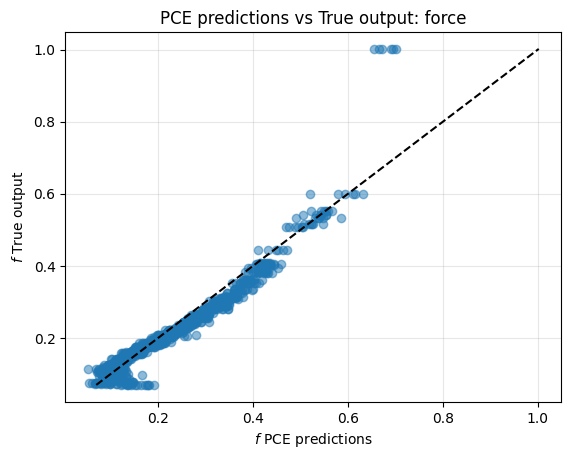

In [37]:
QOI_list = ['force', 'dw', 'ddw']
QOI_symbols = ['$f$', '$\Psi^{\prime}$', '$\Psi^{\prime\prime}$']
iQOI = 0
predictions_plot = predictions_all[:, iQOI]
true_output_plot = true_output_all[:, iQOI]
# predictions_plot = predictions[:, iQOI]
# true_output_plot = true_output[:, iQOI]

plt.plot(predictions_plot, true_output_plot, 'o', alpha=0.5)
# plot line with slope 1
plt.plot([np.min(true_output_plot), np.max(true_output_plot)], [np.min(true_output_plot), np.max(true_output_plot)], 'k--', alpha=1)
plt.xlabel(f"{QOI_symbols[iQOI]} PCE predictions")
plt.ylabel(f"{QOI_symbols[iQOI]} True output")
plt.title(f"PCE predictions vs True output: {QOI_list[iQOI]}")
plt.grid(True, alpha=0.3)
# plt.xlim(-0.1,1.5)
# plt.ylim(-0.1,1.5)

## 2.3 Sensitivity Analysis

In [4]:
'''LOAD RESULTS'''
# os.chdir('..')
# os.chdir('models')
os.getcwd()

'/mnt/c/Users/luisr/OneDrive/Ambiente de Trabalho/PhD/stochastic-biopolymers/notebooks'

In [6]:
os.chdir('..')
os.chdir('models')
os.getcwd()
# file_list = os.listdir('best/1_4_1')
file_list = ['best/1_1/rnd_500_LS_d2', 'best/1_2/LHS_500_LS_d2', 'best/1_3_1/rnd_500_LS_d2', 'best/1_3_2/rnd_2500_LS_d2']
file_id = 'best/1_2/LHS_500_LS_d2'

distributions = {
    'normal': cp.Normal,
    'uniform': cp.Uniform,
    'lognormal': cp.LogNormal,
}

'''LOAD TEST RESULTS AND PCE MODEL FROM A LIST OF MODELS'''
r2score_list = []
test_results_list = []
pce_model_list = []
for file_id in file_list:

    # Load test results from pickle file
    with open(f'{file_id}/test_results.pkl', 'rb') as file:
        test_results = pickle.load(file)

    # Load the pce model from pickle file
    with open(f'{file_id}/pce_model.pkl', 'rb') as file:
        pce_model = pickle.load(file)
    
    # test_results_list.append(test_results)
    pce_model_list.append(pce_model)

'''GET TEST RESULTS FROM INCREASED TEST SETS'''
os.chdir('..')
os.chdir('data')
os.getcwd()

data_file_id = 'test_set_random'
## Load test results
with open(f'filament/{data_file_id}/results.pkl', 'rb') as file:
    df_results = pickle.load(file)

with open(f'filament/{data_file_id}/study_props_info.csv', 'r') as file:
    rnd_inputs = json.load(file)

joint_dist = cp.J(
            *[distributions[value['distribution']](*list(value.values())[1:]) 
            for value in rnd_inputs.values()]
                    )

In [38]:
joint_dist

J(Normal(mu=0.014, sigma=0.0014), Normal(mu=0.5, sigma=0.05), Normal(mu=38600.0, sigma=3860.0), Uniform(lower=1.9, upper=2.1), Uniform(lower=1.55, upper=1.7), Normal(mu=16.0, sigma=1.6), Uniform(lower=1.0, upper=1.2))

In [15]:
pce_id = 1
pce = pce_model_list[pce_id][1.0]
pce

polynomial([8.394621433922326*q6**2+0.11949324852708688*q5*q6+9.22978198838971*q4*q6-8.99250033787642*q3*q6-1.0381239054536138e-05*q2*q6+5.5939781675954245*q1*q6-45.818876326069294*q0*q6-3.387291907302227e-05*q5**2-0.02787930551403024*q3*q5+0.03349342894072869*q4*q5+7.531654000758551e-08*q2*q5+0.02062331510830509*q1*q5+1.5146652915929342*q1*q4+0.07231134159402952*q0*q5+1.5769846616690113*q4**2-3.2168889088145463*q3*q4-8.992142799066126*q0*q4-7.610508769778005e-08*q2*q4-7.121446816340802e-07*q2*q3+1.6109469379074555*q3**2-8.5408888775812*q0*q1-79.60258670284661*q0**2-1.5715280174627773*q1*q3+3.5367084754140454*q0*q3-2.255040020331467e-06*q1*q2-1.9141351347419236e-11*q2**2+0.2947947587574968*q1**2-1.1924527771087368e-05*q0*q2-0.13543377170451093*q5-17.31832688728393*q6+9.279193264400849*q3-9.376585222755516*q4+1.4300197626020919e-05*q2-5.525561514181602*q1+62.42688100691741*q0+8.670518873056746,
            13.68585976460517*q6**2+0.19714540408520434*q5*q6+16.542095226266174*q4*q6-14.826

In [62]:
# SOBOL indices

### FULL POLYNOMIALS

# sobol_indices = cp.Sens_m(pce, joint_dist)
# sobol_indices_t = cp.Sens_t(pce, joint_dist)

# FIXED STRETCH

stretch = 1.05

pce_id = 1
pce = pce_model_list[pce_id][1.0]

# Remove stretch from the joint distribution
joint_dist_fix_stretch = joint_dist[:6]

pce_fix_stretch = pce(*[None, None, None, None, None, None, stretch])

sobol_indices = cp.Sens_m(pce_fix_stretch, joint_dist_fix_stretch)
sobol_indices_t = cp.Sens_t(pce_fix_stretch, joint_dist_fix_stretch)
print(f"Sobol indices m: {sobol_indices}")
print(f"Sobol indices t: {sobol_indices_t}")

stretch = 1.15

pce_id = -1
pce = pce_model_list[pce_id][1.0]

pce_fix_stretch = pce(*[None, None, None, None, None, None, stretch])

sobol_indices_2 = cp.Sens_m(pce_fix_stretch, joint_dist_fix_stretch)
sobol_indices_t_2 = cp.Sens_t(pce_fix_stretch, joint_dist_fix_stretch)
print(f"Sobol indices m: {sobol_indices_2}")
print(f"Sobol indices t: {sobol_indices_t_2}")

Sobol indices m: [[0.00619372 0.00620948 0.00505945]
 [0.0613273  0.05525479 0.00432986]
 [0.00443723 0.00447061 0.00319078]
 [0.33843765 0.30534211 0.38365806]
 [0.19900409 0.23839089 0.29376507]
 [0.02838624 0.02450393 0.02366132]]
Sobol indices t: [[0.0086744  0.00873478 0.00767791]
 [0.1732885  0.16374466 0.04636555]
 [0.00584561 0.00582973 0.00402871]
 [0.63609717 0.60367021 0.63691422]
 [0.46144763 0.51215108 0.5393333 ]
 [0.07686045 0.07169771 0.05201576]]
Sobol indices m: [[3.11367354e-04 3.19833589e-04 8.49640345e-04]
 [1.27925652e-01 1.21096458e-01 6.97774824e-02]
 [9.35504895e-06 8.20220264e-06 1.94263252e-05]
 [4.42670770e-01 4.19244612e-01 4.10151997e-01]
 [2.84742699e-01 3.13608605e-01 3.32698395e-01]
 [2.63379459e-02 2.45977351e-02 1.06465061e-02]]
Sobol indices t: [[0.00066466 0.00068004 0.00187131]
 [0.16927948 0.16237826 0.11954536]
 [0.00065055 0.00066256 0.00169408]
 [0.54102458 0.51959536 0.56020357]
 [0.37362804 0.40675986 0.47546081]
 [0.0327549  0.03104848 0.017

<>:4: SyntaxWarning: invalid escape sequence '\p'
<>:4: SyntaxWarning: invalid escape sequence '\p'
<>:5: SyntaxWarning: invalid escape sequence '\e'
<>:5: SyntaxWarning: invalid escape sequence '\m'
<>:10: SyntaxWarning: invalid escape sequence '\l'
<>:11: SyntaxWarning: invalid escape sequence '\l'
<>:16: SyntaxWarning: invalid escape sequence '\m'
<>:29: SyntaxWarning: invalid escape sequence '\m'
<>:4: SyntaxWarning: invalid escape sequence '\p'
<>:4: SyntaxWarning: invalid escape sequence '\p'
<>:5: SyntaxWarning: invalid escape sequence '\e'
<>:5: SyntaxWarning: invalid escape sequence '\m'
<>:10: SyntaxWarning: invalid escape sequence '\l'
<>:11: SyntaxWarning: invalid escape sequence '\l'
<>:16: SyntaxWarning: invalid escape sequence '\m'
<>:29: SyntaxWarning: invalid escape sequence '\m'
/tmp/ipykernel_832/2231686685.py:4: SyntaxWarning: invalid escape sequence '\p'
  QOI_symbols = ['$f$', '$w^{\prime}$', '$w^{\prime\prime}$']
/tmp/ipykernel_832/2231686685.py:4: SyntaxWarning:

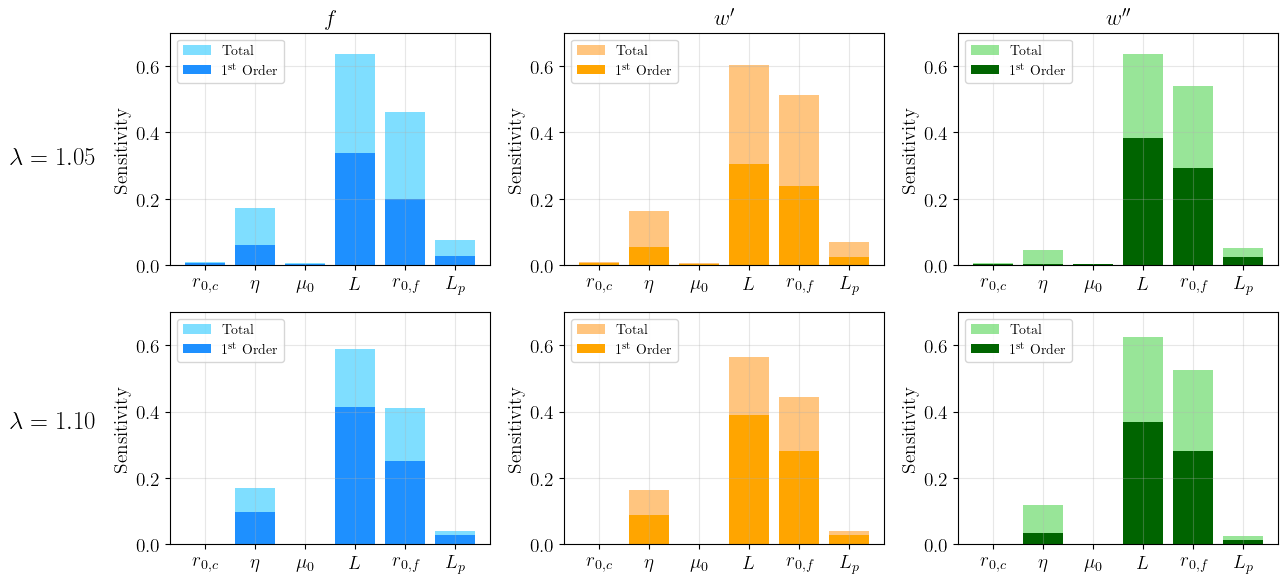

In [ ]:
# Create barplots for the sobol indices (first order and total)
import matplotlib.pyplot as plt

QOI_symbols = ['$f$', '$w^{\prime}$', '$w^{\prime\prime}$']
input_symbols = ['$r_{0,c}$', '$\eta$', '$\mu_0$', '$L$', '$r_{0,f}$', '$L_p$']

fig, axs = plt.subplots(2, 3, figsize=(12, 6))
color_list = [['deepskyblue', 'dodgerblue'], ['darkorange', 'orange'], ['limegreen', 'darkgreen']]

fig.text(-0.035, 0.72, '$\lambda=1.05$', ha='center', va='center', fontsize=18)
fig.text(-0.035, 0.28, '$\lambda=1.10$', ha='center', va='center', fontsize=18)

# First order Sobol indices
for i in range(3):
    axs[0, i].bar(range(len(sobol_indices_t[:,i])), sobol_indices_t[:,i], tick_label=input_symbols, alpha=0.5, color=color_list[i][0], label='Total')
    axs[0, i].bar(range(len(sobol_indices[:,i])), sobol_indices[:,i], tick_label=input_symbols, color=color_list[i][1], label='$1^{\mathrm{st}}$ Order')
    axs[0, i].tick_params(axis='x', labelsize=14)
    axs[0, i].tick_params(axis='y', labelsize=14)
    axs[0, i].set_title(f"{QOI_symbols[i]}", fontsize=16)
    axs[0, i].set_ylabel("Sensitivity", fontsize=14)
    axs[0, i].legend(loc='upper left')
    axs[0,i].set_ylim(0, 0.7)
    axs[0,i].grid(True, alpha=0.3)

# Total Sobol indices
for i in range(3):
    axs[1,i].grid(True, alpha=0.3)
    axs[1, i].bar(range(len(sobol_indices_t_2[:,i])), sobol_indices_t_2[:,i], tick_label=input_symbols, alpha=0.5, color=color_list[i][0], label='Total')
    axs[1, i].bar(range(len(sobol_indices_2[:,i])), sobol_indices_2[:,i], tick_label=input_symbols, color=color_list[i][1], label='$1^{\mathrm{st}}$ Order')
    axs[1, i].tick_params(axis='x', labelsize=14)
    axs[1, i].tick_params(axis='y', labelsize=14)
    axs[1, i].set_ylabel("Sensitivity", fontsize=14)
    axs[1, i].legend(loc='upper left')
    axs[1,i].set_ylim(0, 0.7)

plt.tight_layout()
# os.chdir('..')
# os.chdir('figures')
# plt.savefig('PCE_sobol.svg', bbox_inches='tight')
plt.show()

## 2.4 PCE FE Implementation 

In [ ]:
# os.chdir('..')
os.getcwd()

'/mnt/c/Users/luisr/OneDrive/Ambiente de Trabalho/PhD/stochastic-biopolymers'

In [9]:
# To load
with open('data/abaqus_data.pkl', 'rb') as f:
    abaqus_data = pickle.load(f)

In [ ]:
ax[0].plot(stretch_array, force_array, label='mean', color='blue')
# ax[0].plot(stretch_array, force_array + force_std_array, color='blue', linestyle='--', alpha=0.7, label='std')
# ax[0].plot(stretch_array, force_array - force_std_array, color='blue', linestyle='--', alpha=0.7)
ax[0].errorbar(stretch_array, force_array, yerr=force_std_array, fmt='o', label='std', color='dodgerblue', capsize=3, alpha=0.7)
ax[0].set_ylabel('$f$', fontsize=14)

In [19]:
output = np.load('data/output_econd.npy')
output_plus = np.load('data/output_plus_std.npy')
output_minus = np.load('data/output_minus_std.npy')
output.shape, output_plus.shape, output_minus.shape
output[0], output_plus[0], output_minus[0]

(array([0.        , 0.0025    , 0.005     , 0.00875   , 0.014375  ,
        0.0228125 , 0.03546875, 0.05445312, 0.07945313, 0.10445312,
        0.12945312, 0.15445313, 0.17945312, 0.20445313, 0.22945313,
        0.25      ]),
 array([0.        , 0.0025    , 0.005     , 0.00875   , 0.014375  ,
        0.0228125 , 0.03546875, 0.05445312, 0.07945313, 0.10445312,
        0.12945312, 0.15445313, 0.17945312, 0.20445313, 0.22945313,
        0.25      ]),
 array([0.        , 0.0025    , 0.005     , 0.00875   , 0.014375  ,
        0.0228125 , 0.03546875, 0.05445312, 0.07945313, 0.10445312,
        0.12945312, 0.15445313, 0.17945312, 0.20445313, 0.22945313,
        0.25      ]))

<>:6: SyntaxWarning: invalid escape sequence '\s'
<>:49: SyntaxWarning: invalid escape sequence '\g'
<>:6: SyntaxWarning: invalid escape sequence '\s'
<>:49: SyntaxWarning: invalid escape sequence '\g'
/tmp/ipykernel_843/735387771.py:6: SyntaxWarning: invalid escape sequence '\s'
  stress_symbols = ['a', 'a', '$\sigma_{\mathrm{VM}}$', '$\\sigma_{xx}$', '$\\sigma_{yy}$', '$\\tau_{xy}$', 't']
/tmp/ipykernel_843/735387771.py:49: SyntaxWarning: invalid escape sequence '\g'
  plt.xlabel("$\gamma$", fontsize=20)


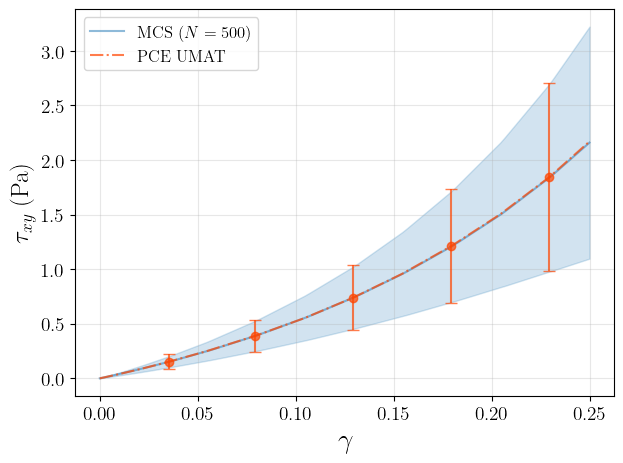

In [90]:
data_list_x = []
data_list_y = []

### N_OUTPUTS = 7 -> u1, u2, s_principal, s11, s22, s12, t

stress_symbols = ['a', 'a', '$\sigma_{\mathrm{VM}}$', '$\\sigma_{xx}$', '$\\sigma_{yy}$', '$\\tau_{xy}$', 't']
stress_idx = -2
n=500

# Example for range 20, 30, 50, 100, 200!!!
for i in range(n):
    data_list_x.append(abaqus_data[i][0, :])
    data_list_y.append(abaqus_data[i][stress_idx, :])

# Common x-grid
all_x = np.concatenate(data_list_x)
x_common = np.linspace(all_x.min(), all_x.max(), 500)

interpolated_ys = []
for x, y in zip(data_list_x, data_list_y):
    f = interp1d(x, y, kind='linear', bounds_error=False, fill_value=np.nan)
    interpolated_ys.append(f(x_common))

data_y_interp = np.vstack(interpolated_ys)

# Create a DataFrame for Seaborn
df = pd.DataFrame(data_y_interp, columns=x_common)
df_melted = df.melt(var_name='x', value_name='y')
df_melted['x'] = df_melted['x'].astype(float)

output_mean = np.load('data/output_econd.npy')
output_plus = np.load('data/output_plus_std.npy')
output_minus = np.load('data/output_minus_std.npy')
output_std = output_plus[stress_idx, :] - output_mean[stress_idx, :]

x = output_mean[0, :]
y = output_mean[stress_idx, :]

step = 2
x_err = x[::step][3:]
y_err = y[::step][3:]
std_err = output_std[::step][3:]

plt.figure()
# sns.lineplot(data=df_melted, x='x', y='y', errorbar='sd', label='MCS ($N=1000$)')
sns.lineplot(data=df_melted, x='x', y='y', errorbar='sd', label=f'MCS ($N={n}$)', alpha=0.5)
plt.plot(x, y, color='orangered', linestyle='-.', label='PCE UMAT', alpha = 0.7)
plt.errorbar(x_err, y_err, yerr=std_err, fmt='o', color='orangered', capsize = 4, alpha = 0.7)
plt.xlabel("$\gamma$", fontsize=20)
plt.ylabel(f"{stress_symbols[stress_idx]} (Pa)", fontsize=18)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.grid(True, alpha=0.3)
plt.legend(fontsize=12)

plt.tight_layout()
plt.savefig('figures/fem_sig12.svg', bbox_inches='tight')
plt.show()

In [99]:
data_list_x = []
data_list_y = []

### N_OUTPUTS = 7 -> u1, u2, s_principal, s11, s22, s12, t

stress_symbols = ['a', 'a', '$\sigma_{\mathrm{VM}}$', '$\\sigma_{xx}$', '$\\sigma_{yy}$', '$\\tau_{xy}$', 't']
stress_idx = -2
n_list=[20, 50, 200, 500]

plt.figure()
# Example for range 20, 50, 100, 200!!!
for n in n_list:
    data_list_x = []
    data_list_y = []
    for i in range(n):
        data_list_x.append(abaqus_data[i][0, :])
        data_list_y.append(abaqus_data[i][stress_idx, :])

    # Common x-grid
    all_x = np.concatenate(data_list_x)
    x_common = np.linspace(all_x.min(), all_x.max(), 500)

    interpolated_ys = []
    for x, y in zip(data_list_x, data_list_y):
        f = interp1d(x, y, kind='linear', bounds_error=False, fill_value=np.nan)
        interpolated_ys.append(f(x_common))

    data_y_interp = np.vstack(interpolated_ys)

    # Create a DataFrame for Seaborn
    df = pd.DataFrame(data_y_interp, columns=x_common)
    df_melted = df.melt(var_name='x', value_name='y')
    df_melted['x'] = df_melted['x'].astype(float)

    x0 = 0.25  # some value in x_common
    print(n, df_melted[df_melted['x'] == x0]['y'].mean())

    # sns.lineplot(data=df_melted, x='x', y='y', errorbar=None, label=f'MCS mean ($N={n}$)', alpha=0.8)

output_mean = np.load('data/output_econd.npy')
x = output_mean[0, :]
y = output_mean[stress_idx, :]


# sns.lineplot(data=df_melted, x='x', y='y', errorbar='sd', label='MCS ($N=1000$)')
# plt.plot(x, y, color='orangered', linestyle='-.', label='PCE UMAT mean', alpha=0.7)
# plt.xlabel("$\gamma$", fontsize=20)
# plt.ylabel(f"{stress_symbols[stress_idx]} (Pa)", fontsize=18)
# plt.xticks(fontsize=14)
# plt.yticks(fontsize=14)
# plt.grid(True, alpha=0.3)
# plt.legend(fontsize=12)

# plt.tight_layout()
# plt.savefig('figures/fem_compare_sig12.svg', bbox_inches='tight')
# plt.show()

20 2.5029774963855744
50 2.4197748482227324
200 2.2074866980314254
500 2.158964160323143


<>:6: SyntaxWarning: invalid escape sequence '\s'
<>:6: SyntaxWarning: invalid escape sequence '\s'
/tmp/ipykernel_843/49481892.py:6: SyntaxWarning: invalid escape sequence '\s'
  stress_symbols = ['a', 'a', '$\sigma_{\mathrm{VM}}$', '$\\sigma_{xx}$', '$\\sigma_{yy}$', '$\\tau_{xy}$', 't']


<Figure size 640x480 with 0 Axes>

-------------------------------------------------------------------------

-------------------------------------------------------------------------

-------------------------------------------------------------------------

-------------------------------------------------------------------------

In [23]:
'''SIMPLE EXAMPLE OF PCE FOR VECTOR OUTPUTS'''

import numpy as np
import chaospy
import sklearn.linear_model

# Define random seed
np.random.seed(0)

# Define the joint distribution
joint_dist = chaospy.J(chaospy.Normal(0, 1), chaospy.Uniform(-1, 1))

# Generate polynomials using the joint distribution
polynomials = chaospy.generate_expansion(2, joint_dist)

# Define the collocation nodes (abscissas) with shape (D, K) = (n_rnd_inputs, n_samples)
abscissas = np.array([[-1, -1, 1, 1],  
                      [-1, 1, -1, 1], 
                      [5, -0, -0, 0]])

# Define the model evaluations (evals) with shape (K, n) = (n_samples, n_outputs)
# Here we obtain 2 polynomials (n=2)
evals = np.array([[1, 2, 2, 4, 5, 6], 
                  [1, 2, 2, 4, 5, 6], 
                  [1, 2, 3, 4, 5, 6], 
                  [1, 2, 3, 4, 5, 6]])

# Fit the polynomial chaos expansion using linear regression
fitted_polynomials = chaospy.fit_regression(polynomials, abscissas, evals)

# Print the fitted polynomials
print(fitted_polynomials)

# Evaluate the fitted polynomials at new points
new_abscissas = np.array([[-1, -1, 1, 1], 
                          [-1, 1, -1, 1], 
                          [-1, 1, -1, 1]])# , [-1, 1, -1, 1], [5, -0, -0, 0]])
predictions = fitted_polynomials(*abscissas)

print(f"Predictions: {predictions}")
print(predictions.shape)

[0.46153846153846195*q1**2+2.220446049250313e-16*q0*q1+1.6653345369377348e-16*q1+0.5384615384615387
 0.9230769230769239*q1**2+4.440892098500626e-16*q0*q1+3.3306690738754696e-16*q1+1.0769230769230773
 1.1538461538461546*q1**2+7.771561172376096e-16*q0*q1+5.551115123125783e-16*q1+0.49999999999999967*q0+1.3461538461538465
 1.8461538461538478*q1**2+8.881784197001252e-16*q0*q1+6.661338147750939e-16*q1+2.1538461538461546
 2.30769230769231*q1**2+1.1102230246251565e-15*q0*q1+2.692307692307694
 2.76923076923077*q1**2+1.3322676295501878e-15*q0*q1+4.440892098500626e-16*q1+8.881784197001252e-16*q0+3.23076923076923]
Predictions: [[1. 1. 1. 1.]
 [2. 2. 2. 2.]
 [2. 2. 3. 3.]
 [4. 4. 4. 4.]
 [5. 5. 5. 5.]
 [6. 6. 6. 6.]]
(6, 4)


In [19]:
import chaospy as cp
import numpy as np

# 1. Define the input distribution (example: 2 independent uniform variables)
dist = cp.Iid(cp.Uniform(0, 1), 4)

# 2. Generate samples (N is number of samples, d is number of variables)
N = 100
samples = dist.sample(N, rule="halton")  # shape: (d, N)

# 3. Evaluate your model for all samples
#    Assume model returns shape (outputs, N)
def model(x):
    # Example: two outputs
    return np.array([
        np.cos(x[0]) + x[1],         # output 1
        10**5 * x[0] * np.sin(x[1])  # output 2
    ])

evals = np.array([model(samples[:, i]) for i in range(N)])  # shape: (outputs, N)

# 4. Define a PCE basis (order=p, d variables)
order = 3
expansion = cp.generate_expansion(order, dist)

# 5. Evaluate the basis at sample locations
# poly_evals = expansion(*samples)  # shape: (num_basis, N)
print(f"samples shape: {samples.shape}, evals shape: {evals.shape}")


# 6. Fit the PCE coefficients in matrix form (multi-output)
#    evals: shape (outputs, N) => columns are samples, rows are outputs
#    poly_evals: shape (num_basis, N)
pce = cp.fit_regression(expansion, samples, evals)

# 7. To evaluate the PCE for new samples:
new_samples = dist.sample(10)
pce_output = pce(*new_samples)
true_output = model(new_samples)  # shape: (outputs, num_new_samples)

pce_output, true_output, pce(*new_samples).shape # shape: (outputs, num_new_samples)

# 8. Each output (row) in `coeffs` or `pce_evals` corresponds to a 
# different output variable.

# Compare 

samples shape: (4, 100), evals shape: (100, 2)


(array([[1.24063585e+00, 9.12802568e-01, 1.38563480e+00, 1.52760224e+00,
         1.04945451e+00, 1.12085051e+00, 1.32505815e+00, 1.62774225e+00,
         1.58230129e+00, 1.36505599e+00],
        [1.34529450e+04, 2.33295293e+04, 4.48144515e+04, 7.20847500e+04,
         1.37879613e+03, 3.62852796e+04, 3.83665542e+03, 3.41528306e+04,
         1.03728351e+03, 4.15465085e+04]]),
 array([[1.24079775e+00, 9.12569934e-01, 1.38546534e+00, 1.52751401e+00,
         1.04926922e+00, 1.12062791e+00, 1.32501292e+00, 1.62787720e+00,
         1.58262455e+00, 1.36497381e+00],
        [1.35403563e+04, 2.31411300e+04, 4.48432660e+04, 7.18988508e+04,
         1.30785075e+03, 3.62466659e+04, 3.98572246e+03, 3.41850058e+04,
         9.70775589e+02, 4.15522810e+04]]),
 (2, 10))

In [ ]:
'''EXAMPLE OF USING MULTIPROCESSING FOR SIMULATIONS'''

from concurrent.futures import ProcessPoolExecutor
import pandas as pd

# Function to run a single simulation
def run_single_simulation(iSample, mat_props_manager, simulation):
    print(f"Running simulation for sample {iSample}")
    mat_props = mat_props_manager.get_material_props(iSample)
    iResults = simulation.run_umat(mat_props)
    print(f"Simulation for sample {iSample} completed.")
    return pd.DataFrame([iResults])

# Parallelized code
# Create empty dataframe for results
df_results = pd.DataFrame()

# Specify the number of CPUs to use
num_cpus = 4  # Replace with the desired number of CPUs

# Use ProcessPoolExecutor for parallel execution
with ProcessPoolExecutor(max_workers=num_cpus) as executor:
    # Submit tasks for each sample
    futures = [executor.submit(run_single_simulation, iSample, self.mat_props_manager, self.simulation)
               for iSample in range(self.n_samples)]
    
    # Collect results as they complete
    for future in futures:
        df_results = pd.concat([df_results, future.result()], axis=0, ignore_index=True)

# Save results to csv
self.simulation.save_results(df_results, self.mat_props_manager.study_props)
print("Study completed.")

In [ ]:
'''TESTING BRENTS METHOD FOR FILAMENT RELATIONS'''

import numpy as np
from scipy.optimize import fsolve, brentq

# Constants (replace with your actual values)
lambda_ = 1.3
lambda_0 = 1.0
r0 = 1.63
L = 1.96
mu0 = 38600.0
beta = 0.5
B0 = 294.0 * 16.0 * 1.38065e-5

# Define the function G(f)
def G(f):
    lhs = (lambda_ * lambda_0 * r0) / L
    aux1 = f / mu0
    aux2 = L**2 / (np.pi**2 * B0)
    num = (1 + 2*aux1) * (1 + aux1)**beta * (1 - r0/L)
    denom = (1 + f*aux2 + f*aux1*aux2)**beta
    rhs = 1 + aux1 - num / denom
    return lhs - rhs

# Solve G(f) = 0 starting from an initial guess
f_solution = fsolve(G, x0=0.1)
print("Solution fsolve: f =", f_solution[0])
b_solution = brentq(G, 0., 1.e20, xtol = 2e-12, maxiter = 100)
print("Solution brentq: f =", b_solution)

Solution fsolve: f = 3186.1201600065315
Solution brentq: f = 3186.1201600065347
